## Complete Step-by-Step Solution: At-Risk Member Prediction & Causal Analytics
-Problem Statement
-Predict members who will make high claims OR develop high-risk conditions in the future (3-12 months   ahead), and identify root causes for actionable interventions.

📋 STEP-BY-STEP SOLUTION ROADMAP
-- PHASE 1: DATA PREPARATION & UNDERSTANDING

STEP 1: Define "At-Risk" Members Clearly
1.1 Business Definition Workshop

In [1]:
# Define what constitutes "at-risk" - get stakeholder agreement

AT_RISK_CRITERIA = {
    'high_claim': {
        'threshold_type': 'percentile',  # or absolute amount
        'threshold_value': 90,  # 90th percentile
        'time_window': '6_months',  # future prediction window
        'min_amount': 1000  # £5,000 minimum
    },
    'high_risk_condition': {
        'conditions': [
            'Cancer',
            'Cardiovascular Disease', 
            'Chronic Kidney Disease',
            'Diabetes Complications',
            'Mental Health Crisis',
            'Musculoskeletal Chronic'
        ],
        'severity_threshold': 'requires_ongoing_treatment'
    }
}

## 1.2 Create Ground Truth Labels

In [3]:
import pandas as pd

In [4]:
claims_df = pd.read_csv("uk_pmi_claims_200k.csv")

In [5]:
membership_df = pd.read_csv("uk_pmi_membership_120k.csv")

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def create_target_labels(claims_df, membership_df, observation_date, prediction_window_months=6):
    """
    Create target variables for at-risk prediction
    
    Parameters:
    - observation_date: Date at which we make prediction (e.g., '2025-01-01')
    - prediction_window_months: How far ahead to predict (default 6 months)
    """
    
    observation_date = pd.to_datetime(observation_date)
    future_end_date = observation_date + timedelta(days=30*prediction_window_months)
    
    # Target 1: High Claim in Future Window
    future_claims = claims_df[
        (pd.to_datetime(claims_df['Paid Date']) > observation_date) &
        (pd.to_datetime(claims_df['Paid Date']) <= future_end_date)
    ]
    
    future_claim_amounts = future_claims.groupby('Claimant Unique ID')['Claim Amount'].sum()
    high_claim_threshold = future_claim_amounts.quantile(0.90)
    
    target_df = membership_df[['Unique ID']].copy()
    target_df['future_total_claims'] = target_df['Unique ID'].map(future_claim_amounts).fillna(0)
    target_df['will_make_high_claim'] = (target_df['future_total_claims'] > high_claim_threshold).astype(int)
    
    # Target 2: High-Risk Condition Development
    high_risk_conditions = [
        'Cancer', 'Cardiovascular', 'Chronic Kidney', 
        'Diabetes', 'Mental Health', 'Chronic Pain'
    ]
    
    future_conditions = future_claims.groupby('Claimant Unique ID')['Condition Category'].apply(
        lambda x: any(condition in str(x).upper() for condition in [c.upper() for c in high_risk_conditions])
    )
    
    target_df['will_develop_high_risk_condition'] = target_df['Unique ID'].map(future_conditions).fillna(0).astype(int)
    
    # Combined Target: At-Risk Member (either high claim OR high-risk condition)
    target_df['is_at_risk'] = (
        (target_df['will_make_high_claim'] == 1) | 
        (target_df['will_develop_high_risk_condition'] == 1)
    ).astype(int)
    
    # Additional: Risk severity score (0-100)
    target_df['risk_severity_score'] = (
        0.6 * target_df['will_make_high_claim'] + 
        0.4 * target_df['will_develop_high_risk_condition']
    ) * 100
    
    return target_df

# Execute
observation_date = '2024-06-01'  # Use as your "present" for prediction
targets = create_target_labels(claims_df, membership_df, observation_date)

print("Target Distribution:")
print(targets['is_at_risk'].value_counts(normalize=True))
print(f"\nAt-risk rate: {targets['is_at_risk'].mean()*100:.2f}%")


Target Distribution:
is_at_risk
0    0.980267
1    0.019733
Name: proportion, dtype: float64

At-risk rate: 1.97%


## STEP 2: Data Integration & Temporal Alignment
#### 2.1 Create Point-in-Time Features

In [13]:
def create_point_in_time_dataset(claims_df, membership_df, observation_date, lookback_months=24):
    """
    Create features using ONLY data available before observation_date
    This prevents data leakage
    """
    
    observation_date = pd.to_datetime(observation_date)
    lookback_start = observation_date - timedelta(days=30*lookback_months)
    
    # Filter historical claims (before observation date)
    historical_claims = claims_df[
        pd.to_datetime(claims_df['Paid Date']) < observation_date
    ].copy()
    
    # Filter to lookback window
    historical_claims = historical_claims[
        pd.to_datetime(historical_claims['Paid Date']) >= lookback_start
    ]
    
    print(f"Historical claims: {len(historical_claims)} records")
    print(f"Date range: {historical_claims['Paid Date'].min()} to {historical_claims['Paid Date'].max()}")
    
    return historical_claims, membership_df

# Execute
observation_date = '2024-06-01'
historical_claims, membership = create_point_in_time_dataset(
    claims_df, membership_df, observation_date, lookback_months=60
)

Historical claims: 148054 records
Date range: 2020-01-23 to 2024-05-31


#### 2.2 Join Tables with Validation

In [ ]:
def join_claims_membership(claims_df, membership_df):
    """
    Join claims and membership with data quality checks
    """
    
    # Check for duplicates
    print("=== Data Quality Checks ===")
    print(f"Duplicate Claim IDs: {claims_df['Claim ID'].duplicated().sum()}")
    print(f"Duplicate Member IDs: {membership_df['Unique ID'].duplicated().sum()}")
    
    # Join
    df = membership_df.merge(
        claims_df,
        left_on='Unique ID',
        right_on='Claimant Unique ID',
        how='left',
        indicator=True
    )
    
    print(f"\nJoin Statistics:")
    print(df['_merge'].value_counts())
    
    # Identify members with no claims
    members_no_claims = df[df['_merge'] == 'left_only']['Unique ID'].nunique()
    print(f"\nMembers with no claims in period: {members_no_claims}")
    
    return df

df = join_claims_membership(historical_claims, membership)

=== Data Quality Checks ===
Duplicate Claim IDs: 0
Duplicate Member IDs: 0

Join Statistics:
_merge
both          148054
left_only      87143
right_only         0
Name: count, dtype: int64

Members with no claims in period: 87143


### STEP 3: Comprehensive Feature Engineering
#### 3.1 Demographic & Membership Features

In [22]:
df.drop(['Client Name_y', 'Client Identifier_y',
       'Scheme Category/ Section Name_y',
       'Scheme Category/ Section Name Identifier_y', 'Status of Member_y','Unique Member Reference_y', 'Contract Start Date_y',
       'Contract End Date_y'],axis=1,inplace=True)

In [23]:
df.columns = [col[:-2] if col.endswith('_x') else col for col in df.columns]


In [76]:
def create_demographic_features(df, observation_date):
    """
    Create demographic and membership-based features
    """
    
    observation_date = pd.to_datetime(observation_date)
    features = df[['Unique ID']].drop_duplicates().copy()
    
    # Age calculation
    features = features.merge(
        df.groupby('Unique ID')['Year of Birth'].first(),
        on='Unique ID'
    )
    features['age'] = observation_date.year - features['Year of Birth']
    
    # Age groups
    features['age_group'] = pd.cut(
        features['age'], 
        bins=[0, 25, 35, 45, 55, 65, 100],
        labels=['<25', '25-34', '35-44', '45-54', '55-64', '65+']
    )
    
   # Merge gender
    features = features.merge(
        df.groupby('Unique ID')['Gender'].first(),
        on='Unique ID'
    )

    # One-hot encode all gender categories
    gender_dummies = pd.get_dummies(features['Gender'], prefix='gender')

    # Combine with main dataset
    features = pd.concat([features, gender_dummies], axis=1)

    # Optionally drop original gender column
    features.drop(columns=['Gender'], inplace=True)
    
    # Membership tenure
    features = features.merge(
        df.groupby('Unique ID')['Original Date of Joining'].first(),
        on='Unique ID'
    )
    features['Original Date of Joining'] = pd.to_datetime(features['Original Date of Joining'])
    features['membership_tenure_days'] = (observation_date - features['Original Date of Joining']).dt.days
    features['membership_tenure_years'] = features['membership_tenure_days'] / 365.25
    
    # Membership status
    features = features.merge(
        df.groupby('Unique ID')['Registration Status'].first(),
        on='Unique ID'
    )
    features['is_active_member'] = (features['Registration Status'] == 'Active').astype(int)
    
    # Scheme information
    features = features.merge(
        df.groupby('Unique ID')['Scheme Category/ Section Name'].first(),
        on='Unique ID'
    )
    
    # Contract duration
    df['Contract Start Date'] = pd.to_datetime(df['Contract Start Date'], errors='coerce')
    df['Contract End Date'] = pd.to_datetime(df['Contract End Date'], errors='coerce')
    
    contract_info = df.groupby('Unique ID').agg({
        'Contract Start Date': 'first',
        'Contract End Date': 'last'
    }).reset_index()
    
    contract_info['contract_duration_days'] = (
        contract_info['Contract End Date'] - contract_info['Contract Start Date']
    ).dt.days
    
    features = features.merge(contract_info[['Unique ID', 'contract_duration_days']], on='Unique ID', how='left')
    
    # Lapse indicator
    features = features.merge(
        df.groupby('Unique ID')['Lapse Date'].first(),
        on='Unique ID'
    )
    features['has_lapsed'] = features['Lapse Date'].notna().astype(int)
    
    return features

demographic_features = create_demographic_features(df, observation_date)
print(f"\nFeatures created: {demographic_features.shape[1]}")
demographic_features.head()



Features created: 16


,Unique ID,Year of Birth,age,age_group,gender_Female,gender_Male,gender_Other,Original Date of Joining,membership_tenure_days,membership_tenure_years,Registration Status,is_active_member,Scheme Category/ Section Name,contract_duration_days,Lapse Date,has_lapsed
0,MEM00000001-01,1968,56,55-64,False,True,False,2018-09-05,2096,5.738535,Active,1,Advanced Cover,365,None,0
1,MEM00000001-02,1967,57,55-64,True,False,False,2019-05-27,1832,5.015743,Active,1,Executive Cover,365,None,0
2,MEM00000002-01,1976,48,45-54,True,False,False,2020-09-11,1359,3.720739,Active,1,Premier Cover,365,None,0
3,MEM00000002-03,2005,19,<25,False,True,False,2019-07-23,1775,4.859685,Active,1,Enhanced Plan,365,None,0
4,MEM00000003-01,1986,38,35-44,False,True,False,2024-04-25,37,0.101300,Active,1,Core Cover,365,None,0


#### 3.2 Historical Claims Features (CRITICAL)

In [ ]:
def create_claims_history_features(claims_df, observation_date):
    """
    Create comprehensive historical claims features
    """
    
    observation_date = pd.to_datetime(observation_date)
    claims_df['Paid Date'] = pd.to_datetime(claims_df['Paid Date'])
    
    # Calculate time periods
    claims_df['months_before_observation'] = (
        (observation_date.year - claims_df['Paid Date'].dt.year) * 12 +
        (observation_date.month - claims_df['Paid Date'].dt.month)
    )
    
    features_list = []
    
    # === 1. BASIC CLAIM COUNTS & AMOUNTS ===
    basic_agg = claims_df.groupby('Claimant Unique ID').agg({
        'Claim ID': 'count',  # total claims
        'Claim Amount': ['sum', 'mean', 'median', 'std', 'min', 'max'],
    }).reset_index()
    
    basic_agg.columns = ['Unique ID', 'total_claims_count', 'total_claim_amount', 
                         'avg_claim_amount', 'median_claim_amount', 'std_claim_amount',
                         'min_claim_amount', 'max_claim_amount']
    
    features_list.append(basic_agg)
    
    # === 2. TIME-WINDOWED FEATURES ===
    time_windows = [3, 6, 12, 24]  # months
    
    for window in time_windows:
        window_claims = claims_df[claims_df['months_before_observation'] <= window]
        
        window_agg = window_claims.groupby('Claimant Unique ID').agg({
            'Claim ID': 'count',
            'Claim Amount': 'sum'
        }).reset_index()
        
        window_agg.columns = ['Unique ID', f'claims_count_{window}m', f'total_amount_{window}m']
        
        features_list.append(window_agg)
    
    # === 3. TEMPORAL PATTERNS ===
    temporal = claims_df.groupby('Claimant Unique ID').agg({
        'Paid Date': ['min', 'max', 'count']
    }).reset_index()
    
    temporal.columns = ['Unique ID', 'first_claim_date', 'last_claim_date', 'claim_count']
    temporal['days_since_first_claim'] = (observation_date - temporal['first_claim_date']).dt.days
    temporal['days_since_last_claim'] = (observation_date - temporal['last_claim_date']).dt.days
    temporal['claim_duration_days'] = (temporal['last_claim_date'] - temporal['first_claim_date']).dt.days
    temporal['avg_days_between_claims'] = temporal['claim_duration_days'] / (temporal['claim_count'] - 1)
    temporal['avg_days_between_claims'] = temporal['avg_days_between_claims'].fillna(0)
    
    features_list.append(temporal[['Unique ID', 'days_since_first_claim', 'days_since_last_claim', 
                                   'claim_duration_days', 'avg_days_between_claims']])
    
    # === 4. CLAIM FREQUENCY TRENDS ===
    # Claims per month over time
    claims_df['claim_year_month'] = claims_df['Paid Date'].dt.to_period('M')
    monthly_claims = claims_df.groupby(['Claimant Unique ID', 'claim_year_month']).size().reset_index(name='monthly_count')
    
    freq_features = monthly_claims.groupby('Claimant Unique ID').agg({
        'monthly_count': ['mean', 'std', 'max']
    }).reset_index()
    
    freq_features.columns = ['Unique ID', 'avg_monthly_claim_frequency', 
                            'std_monthly_claim_frequency', 'max_monthly_claims']
    
    features_list.append(freq_features)
    
    # === 5. CLAIM SEVERITY INDICATORS ===
    # High-cost claims
    high_cost_threshold = claims_df['Claim Amount'].quantile(0.75)
    claims_df['is_high_cost_claim'] = (claims_df['Claim Amount'] > high_cost_threshold).astype(int)
    
    severity = claims_df.groupby('Claimant Unique ID').agg({
        'is_high_cost_claim': 'sum'
    }).reset_index()
    
    severity.columns = ['Unique ID', 'high_cost_claims_count']
    
    # Cost volatility
    cost_volatility = claims_df.groupby('Claimant Unique ID')['Claim Amount'].apply(
        lambda x: x.std() / x.mean() if x.mean() > 0 else 0
    ).reset_index()
    cost_volatility.columns = ['Unique ID', 'claim_amount_cv']  # coefficient of variation
    
    features_list.append(severity)
    features_list.append(cost_volatility)
    
    # === 6. TREND FEATURES (Increasing/Decreasing Claims) ===
    def calculate_trend(group):
        if len(group) < 2:
            return 0
        group = group.sort_values('Paid Date')
        group['time_index'] = range(len(group))
        correlation = group['time_index'].corr(group['Claim Amount'])
        return correlation if not np.isnan(correlation) else 0
    
    trends = claims_df.groupby('Claimant Unique ID').apply(calculate_trend).reset_index()
    trends.columns = ['Unique ID', 'claim_amount_trend']
    
    features_list.append(trends)
    
    # Merge all features
    from functools import reduce
    claims_features = reduce(lambda left, right: left.merge(right, on='Unique ID', how='outer'), features_list)
    
    # Fill NaN with 0 for members with no claims
    claims_features = claims_features.fillna(0)
    
    return claims_features

claims_features = create_claims_history_features(historical_claims, observation_date)
claims_features.describe()
print(f"Claims features created: {claims_features.shape[1]}")


C:\Temp\ipykernel_15380\29807541.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends = claims_df.groupby('Claimant Unique ID').apply(calculate_trend).reset_index()


Claims features created: 26


In [32]:
claims_features.describe()

,total_claims_count,total_claim_amount,avg_claim_amount,median_claim_amount,std_claim_amount,min_claim_amount,max_claim_amount,claims_count_3m,total_amount_3m,claims_count_6m,...,days_since_first_claim,days_since_last_claim,claim_duration_days,avg_days_between_claims,avg_monthly_claim_frequency,std_monthly_claim_frequency,max_monthly_claims,high_cost_claims_count,claim_amount_cv,claim_amount_trend
count,32857.000000,3.285700e+04,32857.000000,32857.000000,32857.000000,32857.000000,32857.000000,32857.000000,3.285700e+04,32857.000000,...,32857.000000,32857.000000,32857.00000,32857.000000,32857.000000,32857.000000,32857.000000,32857.000000,32857.000000,32857.000000
mean,4.506011,2.558287e+04,5477.329289,4278.385454,4080.006793,3116.627819,13236.995414,0.320541,1.818936e+03,0.620659,...,713.900387,623.257997,90.64239,38.289121,1.227895,0.176047,1.480659,1.126518,0.535784,-0.002648
std,35.890613,2.142705e+05,16247.585935,15727.285264,12673.123009,14643.876577,33658.180062,4.926635,2.820913e+04,8.206342,...,418.583053,407.687561,122.78210,61.603699,2.541327,1.200852,3.767306,9.307321,0.753973,0.512540
min,1.000000,4.559000e+01,45.590000,45.590000,0.000000,40.660000,45.590000,0.000000,0.000000e+00,0.000000,...,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000
25%,1.000000,6.366600e+02,508.520000,461.710000,0.000000,232.240000,571.400000,0.000000,0.000000e+00,0.000000,...,354.000000,257.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.809810e+03,1061.190000,814.615000,0.000000,451.340000,1386.110000,0.000000,0.000000e+00,0.000000,...,707.000000,606.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,1.015042e+04,3547.030000,1660.740000,1338.369289,1013.670000,7696.810000,0.000000,0.000000e+00,0.000000,...,1064.000000,966.000000,182.00000,59.000000,1.000000,0.000000,1.000000,1.000000,0.987087,0.000000
max,3974.000000,2.349523e+07,249923.290000,249923.290000,175583.926365,249923.290000,286107.430000,574.000000,2.905958e+06,690.000000,...,1591.000000,1578.000000,440.00000,412.000000,264.933333,111.126355,359.000000,1018.000000,5.341215,1.000000


#### 3.3 Treatment & Condition Features

In [33]:
def create_treatment_condition_features(claims_df):
    """
    Create features from Treatment Type and Condition information
    """
    
    features_list = []
    
    # === 1. TREATMENT TYPE FEATURES ===
    treatment_features = claims_df.groupby('Claimant Unique ID').agg({
        'Treatment Type': lambda x: x.nunique()  # unique treatment types
    }).reset_index()
    treatment_features.columns = ['Unique ID', 'unique_treatment_types']
    
    # Most frequent treatment
    most_frequent_treatment = claims_df.groupby('Claimant Unique ID')['Treatment Type'].agg(
        lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
    ).reset_index()
    most_frequent_treatment.columns = ['Unique ID', 'most_frequent_treatment']
    
    # Treatment diversity (entropy)
    def calculate_entropy(series):
        from scipy.stats import entropy
        value_counts = series.value_counts(normalize=True)
        return entropy(value_counts) if len(value_counts) > 1 else 0
    
    treatment_diversity = claims_df.groupby('Claimant Unique ID')['Treatment Type'].apply(
        calculate_entropy
    ).reset_index()
    treatment_diversity.columns = ['Unique ID', 'treatment_diversity_entropy']
    
    features_list.extend([treatment_features, most_frequent_treatment, treatment_diversity])
    
    # === 2. CONDITION FEATURES ===
    condition_features = claims_df.groupby('Claimant Unique ID').agg({
        'Condition Code': 'nunique',
        'Condition Category': 'nunique'
    }).reset_index()
    condition_features.columns = ['Unique ID', 'unique_condition_codes', 'unique_condition_categories']
    
    # Check for chronic conditions (repeat condition codes)
    repeat_conditions = claims_df.groupby(['Claimant Unique ID', 'Condition Code']).size().reset_index(name='count')
    chronic_indicator = repeat_conditions[repeat_conditions['count'] >= 3].groupby('Claimant Unique ID').size().reset_index()
    chronic_indicator.columns = ['Unique ID', 'chronic_conditions_count']
    
    features_list.extend([condition_features, chronic_indicator])
    
    # === 3. HIGH-RISK CONDITION FLAGS ===
    high_risk_conditions = ['CANCER', 'CARDIOVASCULAR', 'DIABETES', 'CHRONIC KIDNEY', 'MENTAL HEALTH']
    
    def has_high_risk_condition(condition_series):
        condition_text = ' '.join(condition_series.astype(str).str.upper())
        return any(condition in condition_text for condition in high_risk_conditions)
    
    high_risk_flags = claims_df.groupby('Claimant Unique ID')['Condition Category'].apply(
        has_high_risk_condition
    ).reset_index()
    high_risk_flags.columns = ['Unique ID', 'has_high_risk_condition_history']
    high_risk_flags['has_high_risk_condition_history'] = high_risk_flags['has_high_risk_condition_history'].astype(int)
    
    features_list.append(high_risk_flags)
    
    # === 4. TREATMENT LOCATION FEATURES ===
    location_features = claims_df.groupby('Claimant Unique ID').agg({
        'Treatment Location': lambda x: x.nunique()
    }).reset_index()
    location_features.columns = ['Unique ID', 'unique_treatment_locations']
    
    # Inpatient vs Outpatient ratio (if available)
    # This depends on data structure
    
    features_list.append(location_features)
    
    # === 5. PROVIDER DIVERSITY ===
    if 'Provider Type' in claims_df.columns:
        provider_features = claims_df.groupby('Claimant Unique ID').agg({
            'Provider Type': 'nunique'
        }).reset_index()
        provider_features.columns = ['Unique ID', 'unique_providers']
        features_list.append(provider_features)
    
    # Merge all
    from functools import reduce
    treatment_condition_features = reduce(
        lambda left, right: left.merge(right, on='Unique ID', how='outer'), 
        features_list
    )
    
    treatment_condition_features = treatment_condition_features.fillna(0)
    
    return treatment_condition_features

treatment_condition_features = create_treatment_condition_features(historical_claims)
print(f"Treatment/Condition features: {treatment_condition_features.shape[1]}")

Treatment/Condition features: 10


#### 3.4 Risk Score Features (Composite Indicators)

In [53]:
treatment_condition_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32857 entries, 0 to 32856
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unique ID                        32857 non-null  object 
 1   unique_treatment_types           32857 non-null  int64  
 2   most_frequent_treatment          32857 non-null  object 
 3   treatment_diversity_entropy      32857 non-null  float64
 4   unique_condition_codes           32857 non-null  int64  
 5   unique_condition_categories      32857 non-null  int64  
 6   chronic_conditions_count         32857 non-null  float64
 7   has_high_risk_condition_history  32857 non-null  int32  
 8   unique_treatment_locations       32857 non-null  int64  
 9   unique_providers                 32857 non-null  int64  
dtypes: float64(2), int32(1), int64(5), object(2)
memory usage: 2.4+ MB


In [52]:
claims_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32857 entries, 0 to 32856
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unique ID                    32857 non-null  object 
 1   total_claims_count           32857 non-null  int64  
 2   total_claim_amount           32857 non-null  float64
 3   avg_claim_amount             32857 non-null  float64
 4   median_claim_amount          32857 non-null  float64
 5   std_claim_amount             32857 non-null  float64
 6   min_claim_amount             32857 non-null  float64
 7   max_claim_amount             32857 non-null  float64
 8   claims_count_3m              32857 non-null  float64
 9   total_amount_3m              32857 non-null  float64
 10  claims_count_6m              32857 non-null  float64
 11  total_amount_6m              32857 non-null  float64
 12  claims_count_12m             32857 non-null  float64
 13  total_amount_12m

In [43]:
demographic_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Unique ID                      120000 non-null  object        
 1   Year of Birth                  120000 non-null  int64         
 2   age                            120000 non-null  int64         
 3   age_group                      120000 non-null  category      
 4   gender_Female                  120000 non-null  bool          
 5   gender_Male                    120000 non-null  bool          
 6   gender_Other                   120000 non-null  bool          
 7   Original Date of Joining       120000 non-null  datetime64[ns]
 8   membership_tenure_days         120000 non-null  int64         
 9   membership_tenure_years        120000 non-null  float64       
 10  Registration Status            120000 non-null  object        
 11  

In [54]:
def create_risk_score_features(claims_features, demographic_features):
    """
    Create composite risk scores based on multiple factors
    """
    
    # Merge claims and demographic
    merged = demographic_features.merge(claims_features, on='Unique ID', how='left')
    merged = merged.merge(treatment_condition_features, on='Unique ID', how='left')

    # Handle NaNs by dtype
    for col in merged.columns:
        dtype = merged[col].dtype

        # Numeric columns
        if pd.api.types.is_numeric_dtype(dtype):
            merged[col] = merged[col].fillna(0)

        # Boolean columns
        elif pd.api.types.is_bool_dtype(dtype):
            merged[col] = merged[col].fillna(False)

        # Categorical columns
        elif pd.api.types.is_categorical_dtype(dtype):
            merged[col] = merged[col].cat.add_categories(['Unknown']).fillna('Unknown')

        # Object columns (string, text)
        elif pd.api.types.is_object_dtype(dtype):
            merged[col] = merged[col].fillna('Unknown')

        # Anything else — leave untouched
        else:
            pass

    df = merged.copy()

    # === 1. UTILIZATION RISK SCORE ===
    # Normalized by age and membership tenure
    df['claims_per_year'] = df['total_claims_count'] / (df['membership_tenure_years'] + 0.1)
    df['cost_per_year'] = df['total_claim_amount'] / (df['membership_tenure_years'] + 0.1)
    
    # Age-adjusted utilization
    age_avg_claims = df.groupby('age_group')['claims_per_year'].transform('mean')
    df['utilization_vs_age_cohort'] = df['claims_per_year'] / (age_avg_claims + 1)
    
    # === 2. CLAIM ACCELERATION SCORE ===
    # Are claims increasing over time?
    df['claim_acceleration_score'] = (
        (df['claims_count_6m'] / 6) / 
        ((df['claims_count_24m'] - df['claims_count_6m']) / 18 + 0.1)
    )
    df['claim_acceleration_score'] = df['claim_acceleration_score'].replace([np.inf, -np.inf], 0)
    
    # === 3. RECENT ACTIVITY SCORE ===
    df['recent_activity_score'] = (
        0.5 * (df['claims_count_3m'] / (df['total_claims_count'] + 1)) +
        0.3 * (df['total_amount_3m'] / (df['total_claim_amount'] + 1)) +
        0.2 * (1 / (df['days_since_last_claim'] + 30))
    )
    
    # === 4. SEVERITY RISK SCORE ===
    df['severity_risk_score'] = (
        0.4 * (df['high_cost_claims_count'] / (df['total_claims_count'] + 1)) +
        0.3 * (df['max_claim_amount'] / (df['avg_claim_amount'] + 1)) +
        0.3 * df['claim_amount_cv']
    )
    
    # === 5. CHRONICITY SCORE ===
    df['chronicity_score'] = (
        0.5 * df['has_high_risk_condition_history'] +
        0.3 * (df['chronic_conditions_count'] / (df['unique_condition_codes'] + 1)) +
        0.2 * (df['avg_days_between_claims'] < 60).astype(int)
    )
    
    # === 6. COMPOSITE AT-RISK SCORE (0-100) ===
    from sklearn.preprocessing import MinMaxScaler
    
    risk_components = [
        'utilization_vs_age_cohort',
        'claim_acceleration_score', 
        'recent_activity_score',
        'severity_risk_score',
        'chronicity_score'
    ]
    
    scaler = MinMaxScaler()
    df[risk_components] = scaler.fit_transform(df[risk_components])
    
    df['composite_risk_score'] = (
        0.25 * df['utilization_vs_age_cohort'] +
        0.20 * df['claim_acceleration_score'] +
        0.20 * df['recent_activity_score'] +
        0.20 * df['severity_risk_score']+
        0.15 * df['chronicity_score']
    ) * 100
    
    return df

risk_features = create_risk_score_features(claims_features, demographic_features)
risk_features[['Unique ID', 'composite_risk_score']].describe()

C:\Temp\ipykernel_15380\2188301879.py:23: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(dtype):
C:\Temp\ipykernel_15380\2188301879.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_avg_claims = df.groupby('age_group')['claims_per_year'].transform('mean')


,composite_risk_score
count,120000.000000
mean,4.377993
std,3.708574
min,0.327535
25%,3.200204
50%,3.200204
75%,3.200204
max,79.944555


In [57]:
demographic_features.sample(2)

,Unique ID,Year of Birth,age,age_group,gender_Female,gender_Male,gender_Other,Original Date of Joining,membership_tenure_days,membership_tenure_years,Registration Status,is_active_member,Scheme Category/ Section Name,contract_duration_days,Lapse Date,has_lapsed
26963,MEM00011877-01,1972,52,45-54,True,False,False,2018-08-18,2114,5.787817,Active,1,Platinum Plan,365,None,0
70960,MEM00031345-04,2005,19,<25,True,False,False,2021-09-13,992,2.715948,Active,1,Enhanced Plan,365,None,0


In [58]:
claims_features.sample(2)

,Unique ID,total_claims_count,total_claim_amount,avg_claim_amount,median_claim_amount,std_claim_amount,min_claim_amount,max_claim_amount,claims_count_3m,total_amount_3m,...,days_since_first_claim,days_since_last_claim,claim_duration_days,avg_days_between_claims,avg_monthly_claim_frequency,std_monthly_claim_frequency,max_monthly_claims,high_cost_claims_count,claim_amount_cv,claim_amount_trend
24916,MEM00040160-03,5,2522.59,504.518,239.52,652.050033,149.84,1668.34,0.0,0.00,...,1171,885,286,71.5,1.25,0.5,2,0,1.292422,0.053381
10956,MEM00017639-01,3,6821.43,2273.810,1809.18,2331.637829,209.47,4802.78,1.0,1809.18,...,436,73,363,181.5,1.00,0.0,1,1,1.025432,0.343044


In [59]:
treatment_condition_features.sample(2)

,Unique ID,unique_treatment_types,most_frequent_treatment,treatment_diversity_entropy,unique_condition_codes,unique_condition_categories,chronic_conditions_count,has_high_risk_condition_history,unique_treatment_locations,unique_providers
13257,MEM00021374-01,3,Specialist Consultation,1.039721,4,4,0.0,0,4,4
19516,MEM00031370-02,1,Specialist Consultation,0.000000,1,1,0.0,0,1,1


In [60]:
targets.sample(2)

,Unique ID,future_total_claims,will_make_high_claim,will_develop_high_risk_condition,is_at_risk,risk_severity_score
34310,MEM00015158-02,0.0,0,0,0,0.0
8225,MEM00003601-02,0.0,0,0,0,0.0


In [61]:
risk_features.sample(2)

,Unique ID,Year of Birth,age,age_group,gender_Female,gender_Male,gender_Other,Original Date of Joining,membership_tenure_days,membership_tenure_years,...,unique_treatment_locations,unique_providers,claims_per_year,cost_per_year,utilization_vs_age_cohort,claim_acceleration_score,recent_activity_score,severity_risk_score,chronicity_score,composite_risk_score
80590,MEM00035619-02,1980,44,35-44,False,True,False,2018-08-13,2119,5.801506,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.008259,0.000000,0.202335,3.200204
45052,MEM00019871-01,1982,42,35-44,False,True,False,2021-01-15,1233,3.375770,...,3.0,2.0,0.863118,11988.284539,0.000994,0.00072,0.449680,0.064358,0.505837,17.907542


In [64]:
risk_features.columns

Index(['Unique ID', 'Year of Birth', 'age', 'age_group', 'gender_Female',
       'gender_Male', 'gender_Other', 'Original Date of Joining',
       'membership_tenure_days', 'membership_tenure_years',
       'Registration Status', 'is_active_member',
       'Scheme Category/ Section Name', 'contract_duration_days', 'Lapse Date',
       'has_lapsed', 'total_claims_count', 'total_claim_amount',
       'avg_claim_amount', 'median_claim_amount', 'std_claim_amount',
       'min_claim_amount', 'max_claim_amount', 'claims_count_3m',
       'total_amount_3m', 'claims_count_6m', 'total_amount_6m',
       'claims_count_12m', 'total_amount_12m', 'claims_count_24m',
       'total_amount_24m', 'days_since_first_claim', 'days_since_last_claim',
       'claim_duration_days', 'avg_days_between_claims',
       'avg_monthly_claim_frequency', 'std_monthly_claim_frequency',
       'max_monthly_claims', 'high_cost_claims_count', 'claim_amount_cv',
       'claim_amount_trend', 'unique_treatment_types',
     

### 3.5 Merge All Features

In [68]:
def create_master_feature_set(risk_features, targets):
    """
    Combine all feature sets into final dataset
    """
    
    # Start with risk_features
    master_df = risk_features.copy()
    
    # Add targets
    master_df = master_df.merge(targets, on='Unique ID', how='left')

    
    
    print(f"Master dataset shape: {master_df.shape}")
    print(f"Features: {master_df.shape[1] - 5}")  # excluding ID and targets
    
    return master_df

master_df = create_master_feature_set(
    risk_features,
    targets
)

print("\nFeature Summary:")
print(master_df.dtypes.value_counts())
print(f"\nMissing values: {master_df.isnull().sum().sum()}")

Master dataset shape: (120000, 63)
Features: 58

Feature Summary:
float64           44
object             5
int32              5
int64              4
bool               3
category           1
datetime64[ns]     1
Name: count, dtype: int64

Missing values: 0


#### STEP 4: Data Preprocessing
##### 4.1 Handle Missing Values & Outliers

In [ ]:
def preprocess_features(df):
    """
    Final preprocessing before modeling
    """
    
    # === 1. HANDLE MISSING VALUES ===
    print("Missing values before imputation:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    # Numerical: median imputation
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
    
    # === 2. HANDLE OUTLIERS (CAP AT 99TH PERCENTILE) ===
    cost_columns = [col for col in df.columns if 'amount' in col.lower() or 'cost' in col.lower()]
    
    for col in cost_columns:
        if df[col].dtype in [np.float64, np.int64]:
            p99 = df[col].quantile(0.99)
            df[col] = df[col].clip(upper=p99)
    
    # === 3. HANDLE INFINITE VALUES ===
    df = df.replace([np.inf, -np.inf], 0)
    
    # === 4. ENCODE CATEGORICAL VARIABLES ===
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # For high cardinality categoricals, use target encoding (do this during modeling)
    # For low cardinality, use one-hot encoding
    
    low_cardinality = []
    for col in categorical_cols:
        if df[col].nunique() <= 10:
            low_cardinality.append(col)
    
    df = pd.get_dummies(df, columns=low_cardinality, drop_first=True)
    
    print(f"\nAfter preprocessing: {df.shape}")
    
    return df

processed_df = preprocess_features(master_df)

Missing values before imputation:
Series([], dtype: int64)

After preprocessing: (120000, 68)


In [78]:
processed_df.columns

Index(['Unique ID', 'Year of Birth', 'age', 'gender_Female', 'gender_Male',
       'gender_Other', 'Original Date of Joining', 'membership_tenure_days',
       'membership_tenure_years', 'is_active_member',
       'Scheme Category/ Section Name', 'contract_duration_days', 'Lapse Date',
       'has_lapsed', 'total_claims_count', 'total_claim_amount',
       'avg_claim_amount', 'median_claim_amount', 'std_claim_amount',
       'min_claim_amount', 'max_claim_amount', 'claims_count_3m',
       'total_amount_3m', 'claims_count_6m', 'total_amount_6m',
       'claims_count_12m', 'total_amount_12m', 'claims_count_24m',
       'total_amount_24m', 'days_since_first_claim', 'days_since_last_claim',
       'claim_duration_days', 'avg_days_between_claims',
       'avg_monthly_claim_frequency', 'std_monthly_claim_frequency',
       'max_monthly_claims', 'high_cost_claims_count', 'claim_amount_cv',
       'claim_amount_trend', 'unique_treatment_types',
       'most_frequent_treatment', 'treatment_div

# 4.2 Feature Selection

In [79]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

def select_important_features(df, target_col='is_at_risk', top_k=50):
    """
    Select most important features using variance filtering,
    univariate tests, and tree-based importance.
    Automatically handles datetime, bool, and categorical columns.
    """
    
    # --- 1. Separate features and target
    feature_cols = [col for col in df.columns if col not in [
        'Unique ID', 'is_at_risk', 'will_make_high_claim', 
        'will_develop_high_risk_condition', 'future_total_claims', 'risk_severity_score'
    ]]
    
    X = df[feature_cols].copy()
    y = df[target_col]

    # --- 2. Drop or encode unsupported dtypes
    # Convert bool → int, drop datetime/object/categorical
    drop_cols = []
    for col in X.columns:
        if np.issubdtype(X[col].dtype, np.datetime64):
            drop_cols.append(col)
        elif pd.api.types.is_bool_dtype(X[col]):
            X[col] = X[col].astype(int)
        elif pd.api.types.is_object_dtype(X[col]) or pd.api.types.is_categorical_dtype(X[col]):
            # Convert to category codes (or drop if too many unique)
            if X[col].nunique() < 50:
                X[col] = X[col].astype('category').cat.codes
            else:
                drop_cols.append(col)

    if drop_cols:
        print(f"Dropping non-numeric/unencoded columns: {drop_cols}")
        X = X.drop(columns=drop_cols)
    
    # Replace any remaining NaNs with 0 (safe for numeric)
    X = X.fillna(0)

    # --- 3. Remove low variance features
    selector = VarianceThreshold(threshold=0.01)
    X_high_var = selector.fit_transform(X)
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"✅ Features after variance filter: {len(selected_features)}")

    # --- 4. Univariate feature selection (ANOVA F-test)
    X_selected = X[selected_features]
    selector = SelectKBest(f_classif, k=min(top_k, len(selected_features)))
    selector.fit(X_selected, y)
    
    feature_scores = pd.DataFrame({
        'feature': selected_features,
        'score': selector.scores_
    }).sort_values('score', ascending=False)
    
    print("\n📊 Top 20 features by F-score:")
    print(feature_scores.head(20))

    # --- 5. Random Forest feature importance
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_selected, y)
    
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🌳 Top 20 features by Random Forest importance:")
    print(feature_importance.head(20))

    # --- 6. Combine top features from both methods
    top_features_f = set(feature_scores.head(top_k)['feature'])
    top_features_rf = set(feature_importance.head(top_k)['feature'])
    final_features = list(top_features_f.union(top_features_rf))
    
    print(f"\n🏁 Final selected features: {len(final_features)}")
    
    return final_features, feature_importance



selected_features, feature_importance = select_important_features(processed_df)



C:\Temp\ipykernel_15380\691388711.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(X[col]) or pd.api.types.is_categorical_dtype(X[col]):
C:\Temp\ipykernel_15380\691388711.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(X[col]) or pd.api.types.is_categorical_dtype(X[col]):
C:\Temp\ipykernel_15380\691388711.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(X[col]) or pd.api.types.is_categorical_dtype(X[col]):
C:\Temp\ipykernel_15380\691388711.py:30: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.Cate

Dropping non-numeric/unencoded columns: ['Original Date of Joining', 'Lapse Date']
✅ Features after variance filter: 55

📊 Top 20 features by F-score:
                        feature        score
18              total_amount_3m  9040.490229
46        recent_activity_score  7524.030475
20              total_amount_6m  7227.992409
48         composite_risk_score  4844.308412
22             total_amount_12m  3605.457649
17              claims_count_3m  2160.144243
19              claims_count_6m  2136.104755
6       membership_tenure_years  2027.724421
5        membership_tenure_days  2027.724421
24             total_amount_24m  1479.041411
45                cost_per_year  1215.600265
21             claims_count_12m  1173.332588
42   unique_treatment_locations   916.852701
38       unique_condition_codes   894.300686
35       unique_treatment_types   873.148338
39  unique_condition_categories   816.538978
43             unique_providers   741.996197
37  treatment_diversity_entropy   728.6

In [112]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 67 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Unique ID                         120000 non-null  object        
 1   Year of Birth                     120000 non-null  float64       
 2   age                               120000 non-null  float64       
 3   gender_Female                     120000 non-null  bool          
 4   gender_Male                       120000 non-null  bool          
 5   gender_Other                      120000 non-null  bool          
 6   Original Date of Joining          120000 non-null  datetime64[ns]
 7   membership_tenure_days            120000 non-null  float64       
 8   membership_tenure_years           120000 non-null  float64       
 9   is_active_member                  120000 non-null  float64       
 10  Scheme Category/ Section Name   

In [113]:
processed_df.drop(['Original Date of Joining'],axis=1,inplace=True)

In [105]:
processed_df.drop(['Lapse Date'],axis=1,inplace=True)

#### STEP 5: Model Development
### 5.1 Train-Test Split (Time-Based)

In [114]:
from sklearn.model_selection import train_test_split
def create_train_test_split(df, selected_features, target_col='is_at_risk', test_size=0.2):
    """
    Create train-test split with stratification
    """
    
    # Separate features and target
    X = df[selected_features]
    y = df[target_col]
    
    # Check class imbalance
    print("Class distribution:")
    print(y.value_counts(normalize=True))
    
    # Stratified split to maintain class balance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42,
        stratify=y
    )
    
    print(f"\nTraining set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"At-risk rate in train: {y_train.mean():.2%}")
    print(f"At-risk rate in test: {y_test.mean():.2%}")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test_split(
    processed_df, 
    selected_features
)

Class distribution:
is_at_risk
0.0    0.980267
1.0    0.019733
Name: proportion, dtype: float64

Training set: (96000, 54)
Test set: (24000, 54)
At-risk rate in train: 1.97%
At-risk rate in test: 1.98%


#### 5.2 Handle Class Imbalance

## handing categorical features

In [156]:
def comprehensive_preprocessing(df, target_col='is_at_risk', test_size=0.2):
    """
    Complete preprocessing including categorical encoding
    """
    
    print("=== STARTING COMPREHENSIVE PREPROCESSING ===\n")
    
    # Separate target and features
    exclude_cols = [
        'Unique ID', 'is_at_risk', 'will_make_high_claim', 
        'will_develop_high_risk_condition', 'future_total_claims', 
        'risk_severity_score', 'Member_ID'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Check data types
    print("Data types before preprocessing:")
    print(df[feature_cols].dtypes.value_counts())
    
    # Identify categorical and numerical columns
    categorical_cols = df[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Numerical columns ({len(numerical_cols)}): {len(numerical_cols)} columns")
    
    # === STEP 1: Handle Categorical Variables ===
    df_processed = df.copy()
    
    # Check cardinality of categorical variables
    print("\n=== Categorical Variable Cardinality ===")
    for col in categorical_cols:
        n_unique = df_processed[col].nunique()
        print(f"{col}: {n_unique} unique values")
    
    # Separate low and high cardinality categoricals
    low_cardinality = []
    high_cardinality = []
    
    for col in categorical_cols:
        n_unique = df_processed[col].nunique()
        if n_unique <= 10:
            low_cardinality.append(col)
        else:
            high_cardinality.append(col)
    
    print(f"\nLow cardinality (≤10 unique): {low_cardinality}")
    print(f"High cardinality (>10 unique): {high_cardinality}")
    
    # === STEP 2: Encode Low Cardinality with One-Hot Encoding ===
    if low_cardinality:
        print(f"\nApplying One-Hot Encoding to {len(low_cardinality)} columns...")
        df_processed = pd.get_dummies(
            df_processed, 
            columns=low_cardinality, 
            drop_first=True,
            prefix=low_cardinality
        )
    
    # === STEP 3: Encode High Cardinality with Label/Frequency Encoding ===
    if high_cardinality:
        print(f"\nApplying Frequency Encoding to {len(high_cardinality)} columns...")
        
        for col in high_cardinality:
            # Frequency encoding (replace with frequency of occurrence)
            freq_encoding = df_processed[col].value_counts(normalize=True).to_dict()
            df_processed[f'{col}_freq'] = df_processed[col].map(freq_encoding)
            
            # Drop original column
            df_processed = df_processed.drop(columns=[col])
    
    # === STEP 4: Handle Missing Values ===
    print("\n=== Handling Missing Values ===")
    missing_summary = df_processed.isnull().sum()
    missing_summary = missing_summary[missing_summary > 0]
    
    if len(missing_summary) > 0:
        print(f"Columns with missing values:\n{missing_summary}")
        
        # Fill numerical with median
        numerical_cols_processed = df_processed.select_dtypes(include=[np.number]).columns
        df_processed[numerical_cols_processed] = df_processed[numerical_cols_processed].fillna(
            df_processed[numerical_cols_processed].median()
        )
    else:
        print("No missing values found")
    
    # === STEP 5: Remove Non-Feature Columns ===
    final_feature_cols = [col for col in df_processed.columns if col not in exclude_cols]
    
    X = df_processed[final_feature_cols]
    y = df_processed[target_col]
    
    print(f"\n=== Final Dataset ===")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"All features are numeric: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")
    
    # === STEP 6: Train-Test Split ===
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42,
        stratify=y
    )
    
    print(f"\nTrain set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Class distribution in train: {y_train.value_counts(normalize=True).to_dict()}")
    
    return X_train, X_test, y_train, y_test, final_feature_cols

# Apply preprocessing
X_train, X_test, y_train, y_test, final_features = comprehensive_preprocessing(
    processed_df,
    target_col='is_at_risk',
    test_size=0.2
)

=== STARTING COMPREHENSIVE PREPROCESSING ===

Data types before preprocessing:
float64    48
bool       10
object      2
Name: count, dtype: int64

Categorical columns (2): ['Scheme Category/ Section Name', 'most_frequent_treatment']
Numerical columns (48): 48 columns

=== Categorical Variable Cardinality ===
Scheme Category/ Section Name: 12 unique values
most_frequent_treatment: 15 unique values

Low cardinality (≤10 unique): []
High cardinality (>10 unique): ['Scheme Category/ Section Name', 'most_frequent_treatment']

Applying Frequency Encoding to 2 columns...

=== Handling Missing Values ===
No missing values found

=== Final Dataset ===
Features shape: (120000, 60)
Target shape: (120000,)
All features are numeric: False

Train set: (96000, 60)
Test set: (24000, 60)
Class distribution in train: {0.0: 0.9802708333333333, 1.0: 0.019729166666666666}


In [166]:
## Convert all the bool features into 1 & 0

In [160]:
X_train = X_train.copy()  # to avoid modifying original

# Identify all boolean columns
bool_cols = X_train.select_dtypes(include=['bool']).columns

# Convert them to integers (True → 1, False → 0)
X_train[bool_cols] = X_train[bool_cols].astype(int)

print(f"Converted {len(bool_cols)} boolean columns → numeric (1/0).")


Converted 10 boolean columns → numeric (1/0).


In [162]:
import subprocess, sys

def ensure_versions():
    import sklearn, imblearn
    skl, imb = sklearn.__version__, imblearn.__version__
    print(f"Detected scikit-learn={skl}, imbalanced-learn={imb}")
    if tuple(map(int, skl.split('.')[:2])) < (1, 2):
        print("🔄 Fixing versions...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "scikit-learn==1.4.2", "imbalanced-learn==0.12.0"])

ensure_versions()


Detected scikit-learn=1.7.2, imbalanced-learn=0.14.0


In [168]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

def balance_classes(X_train, y_train, method='smote', balance_ratio=0.5):
    """
    Handles class imbalance safely and version-independently.
    - Works with any sklearn/imblearn version
    - Supports numeric, categorical, and boolean columns
    - balance_ratio: proportion of majority samples to create for the minority class (1.0 = full match)
    """
    print("Before balancing:")
    print(pd.Series(y_train).value_counts(), "\n")

    # Convert to DataFrame/Series
    X_train = pd.DataFrame(X_train).copy()
    y_train = pd.Series(y_train).copy()

    # Encode categorical labels if needed
    if y_train.dtype == 'object':
        y_train = LabelEncoder().fit_transform(y_train)

    df_train = X_train.copy()
    df_train['target'] = y_train

    # Split majority and minority classes
    class_counts = df_train['target'].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()

    majority_df = df_train[df_train['target'] == majority_class]
    minority_df = df_train[df_train['target'] == minority_class]

    if method in ('smote', 'oversample'):
        n_samples = int(len(majority_df) * balance_ratio)
        minority_upsampled = resample(
            minority_df,
            replace=True,
            n_samples=n_samples,
            random_state=42
        )
        balanced_df = pd.concat([majority_df, minority_upsampled])

    elif method == 'undersample':
        n_samples = int(len(majority_df) * balance_ratio)
        majority_downsampled = resample(
            majority_df,
            replace=False,
            n_samples=n_samples,
            random_state=42
        )
        balanced_df = pd.concat([majority_downsampled, minority_df])

    elif method == 'combined':
        n_up = int(len(majority_df) * 0.8 * balance_ratio)
        n_down = int(len(majority_df) * 0.8)
        minority_upsampled = resample(minority_df, replace=True, n_samples=n_up, random_state=42)
        majority_downsampled = resample(majority_df, replace=False, n_samples=n_down, random_state=42)
        balanced_df = pd.concat([majority_downsampled, minority_upsampled])

    else:
        balanced_df = df_train.copy()

    # Shuffle
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate back into X and y
    X_resampled = balanced_df.drop(columns=['target'])
    y_resampled = balanced_df['target']

    print("After balancing:")
    print(y_resampled.value_counts(), "\n")

    return X_resampled, y_resampled

# 80% balancing (minority class = 80% of majority)
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train, method='smote', balance_ratio=0.5)


Before balancing:
is_at_risk
0.0    94106
1.0     1894
Name: count, dtype: int64 

After balancing:
target
0.0    94106
1.0    47053
Name: count, dtype: int64 



In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

def train_baseline_models(X_train, X_test, y_train, y_test):
    """
    Train and compare multiple models
    """
    
    # Calculate class weight for imbalanced data
    from sklearn.utils.class_weight import compute_class_weight
    
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
    scale_pos_weight = class_weight_dict[1] / class_weight_dict[0]
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            class_weight='balanced',
            random_state=42,
            verbose=-1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Evaluate
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        
        results[name] = {
            'model': model,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"{name} - ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    
    # Compare models
    comparison_df = pd.DataFrame({
        'Model': list(results.keys()),
        'ROC-AUC': [results[m]['roc_auc'] for m in results.keys()],
        'PR-AUC': [results[m]['pr_auc'] for m in results.keys()]
    }).sort_values('PR-AUC', ascending=False)
    
    print("\n=== Model Comparison ===")
    print(comparison_df)
    
    return results, comparison_df

# Train models
model_results, comparison = train_baseline_models(
    X_train, X_test, y_train, y_test
)


Training Logistic Regression...


c:\Users\sumit\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - ROC-AUC: 0.8584, PR-AUC: 0.1971

Training Random Forest...
Random Forest - ROC-AUC: 0.8605, PR-AUC: 0.2380

Training Gradient Boosting...
Gradient Boosting - ROC-AUC: 0.8762, PR-AUC: 0.2449

Training XGBoost...
XGBoost - ROC-AUC: 0.8706, PR-AUC: 0.2690

Training LightGBM...
LightGBM - ROC-AUC: 0.8695, PR-AUC: 0.2738

=== Model Comparison ===
                 Model   ROC-AUC    PR-AUC
4             LightGBM  0.869506  0.273751
3              XGBoost  0.870644  0.268995
2    Gradient Boosting  0.876179  0.244863
1        Random Forest  0.860548  0.238039
0  Logistic Regression  0.858447  0.197069


In [170]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import optuna
from optuna.samplers import TPESampler

def tune_lightgbm(X_train, y_train, X_test, y_test, n_trials=50):
    """
    Hyperparameter tuning using Optuna for LightGBM
    """
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'class_weight': 'balanced',
            'random_state': 42,
            'verbose': -1
        }
        
        model = LGBMClassifier(**params)
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Use PR-AUC as optimization metric
            precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
            pr_auc = auc(recall, precision)
            cv_scores.append(pr_auc)
        
        return np.mean(cv_scores)
    
    # Run optimization
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print("\n=== Best Parameters ===")
    print(study.best_params)
    print(f"Best PR-AUC: {study.best_value:.4f}")
    
    # Train final model with best parameters
    best_params = study.best_params
    best_params['class_weight'] = 'balanced'
    best_params['random_state'] = 42
    best_params['verbose'] = -1
    
    best_model = LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)
    
    return best_model, study.best_params

# Tune model
print("Starting hyperparameter tuning...")
best_model, best_params = tune_lightgbm(
    X_train, y_train, 
    X_test, y_test,
    n_trials=50
)

[I 2025-11-08 21:52:12,128] A new study created in memory with name: no-name-bfdc2b53-ccd8-4462-ae67-ae97ed3ae626


Starting hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-08 21:52:19,371] Trial 0 finished with value: 0.15423290813138232 and parameters: {'n_estimators': 250, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 24, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.15423290813138232.
[I 2025-11-08 21:52:31,665] Trial 1 finished with value: 0.2453595413849377 and parameters: {'n_estimators': 383, 'learning_rate': 0.010725209743171996, 'max_depth': 12, 'num_leaves': 87, 'min_child_samples': 29, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.2453595413849377.
[I 2025-11-08 21:52:39,378] Trial 2 finished with value: 0.2518825567184999 and parameters: {'n_estimators': 273, 'learning_rate': 0.02692655251486473, 'max_depth': 9, 'num_leaves': 31, 'min

#### 5.5 Final Model Evaluation

=== CLASSIFICATION METRICS ===
Accuracy: 0.6458
Precision: 0.0501
Recall (Sensitivity): 0.9430
F1-Score: 0.0952
ROC-AUC: 0.8793
PR-AUC: 0.2751
Average Precision: 0.2754


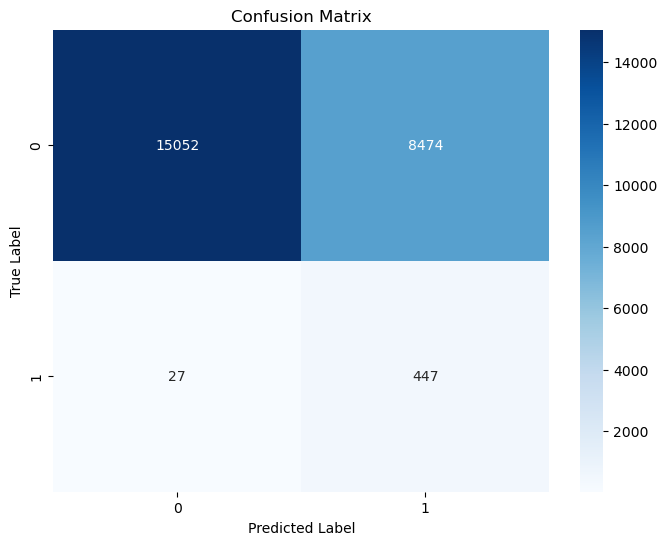


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

 Not At-Risk       1.00      0.64      0.78     23526
     At-Risk       0.05      0.94      0.10       474

    accuracy                           0.65     24000
   macro avg       0.52      0.79      0.44     24000
weighted avg       0.98      0.65      0.77     24000



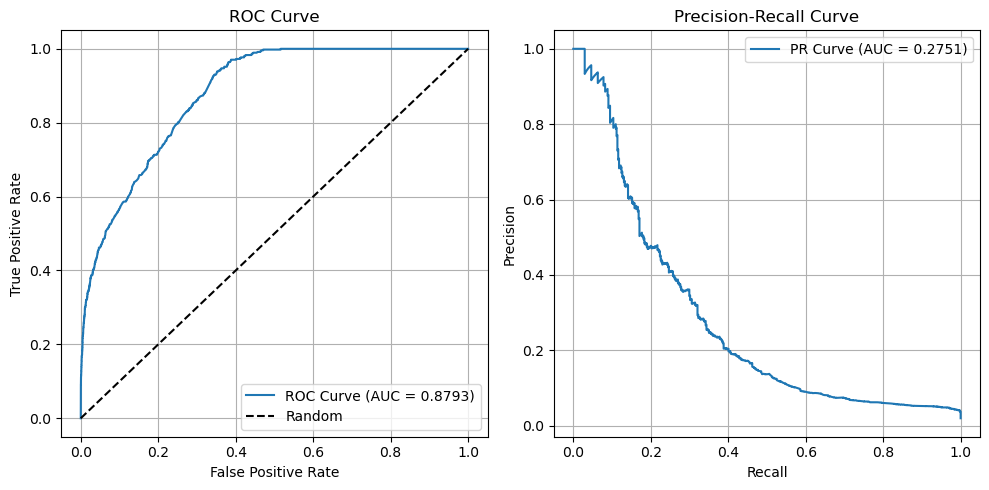


=== DECILE ANALYSIS ===
        Total  At-Risk Count  At-Risk Rate  Cumulative At-Risk %
decile                                                          
10       2401            0.0        0.0000                  0.00
9        2399            0.0        0.0000                  0.00
8        2612            0.0        0.0000                  0.00
7        2189            0.0        0.0000                  0.00
6        2399            1.0        0.0004                  0.21
5        2410           13.0        0.0054                  2.95
4        2393           58.0        0.0242                 15.19
3        2401           64.0        0.0267                 28.69
2        2434           78.0        0.0320                 45.15
1        2362          260.0        0.1101                100.00


C:\Temp\ipykernel_15380\1029785841.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = results_df.groupby('decile').agg({


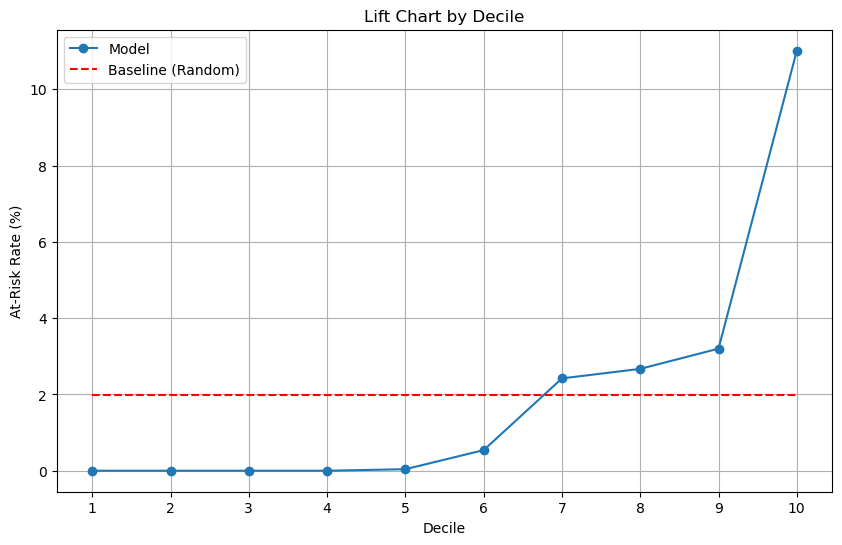

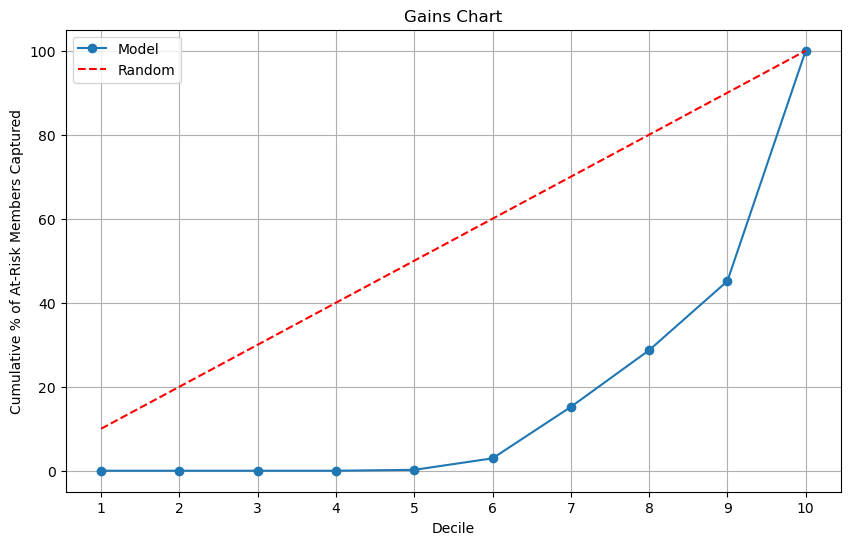


=== OPTIMAL THRESHOLD ANALYSIS ===
   Threshold  Precision    Recall        F1        F2
0        0.3   0.044645  0.978903  0.085396  0.188787
1        0.4   0.047272  0.970464  0.090152  0.197815
2        0.5   0.050106  0.943038  0.095157  0.206619
3        0.6   0.074249  0.698312  0.134225  0.260466
4        0.7   0.164045  0.462025  0.242123  0.338904


In [171]:
def comprehensive_evaluation(model, X_test, y_test, threshold=0.5):
    """
    Comprehensive model evaluation
    """
    
    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # === 1. CLASSIFICATION METRICS ===
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, 
        f1_score, roc_auc_score, average_precision_score
    )
    
    print("=== CLASSIFICATION METRICS ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall (Sensitivity): {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")
    
    # === 2. CONFUSION MATRIX ===
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # === 3. CLASSIFICATION REPORT ===
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred, target_names=['Not At-Risk', 'At-Risk']))
    
    # === 4. ROC CURVE ===
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    
    # === 5. PRECISION-RECALL CURVE ===
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # === 6. DECILE ANALYSIS ===
    print("\n=== DECILE ANALYSIS ===")
    
    results_df = pd.DataFrame({
        'actual': y_test.values,
        'predicted_proba': y_pred_proba
    })
    
    results_df['decile'] = pd.qcut(
        results_df['predicted_proba'], 
        q=10, 
        labels=range(10, 0, -1),
        duplicates='drop'
    )
    
    decile_analysis = results_df.groupby('decile').agg({
        'actual': ['count', 'sum', 'mean']
    }).round(4)
    
    decile_analysis.columns = ['Total', 'At-Risk Count', 'At-Risk Rate']
    decile_analysis['Cumulative At-Risk %'] = (
        decile_analysis['At-Risk Count'].cumsum() / 
        decile_analysis['At-Risk Count'].sum() * 100
    ).round(2)
    
    print(decile_analysis)
    
    # === 7. LIFT CHART ===
    plt.figure(figsize=(10, 6))
    
    x = range(1, len(decile_analysis) + 1)
    baseline = [y_test.mean() * 100] * len(decile_analysis)
    
    plt.plot(x, decile_analysis['At-Risk Rate'] * 100, marker='o', label='Model')
    plt.plot(x, baseline, 'r--', label='Baseline (Random)')
    plt.xlabel('Decile')
    plt.ylabel('At-Risk Rate (%)')
    plt.title('Lift Chart by Decile')
    plt.legend()
    plt.grid(True)
    plt.xticks(x)
    plt.show()
    
    # === 8. GAINS CHART ===
    plt.figure(figsize=(10, 6))
    
    plt.plot(x, decile_analysis['Cumulative At-Risk %'], marker='o', label='Model')
    plt.plot(x, [i*10 for i in x], 'r--', label='Random')
    plt.xlabel('Decile')
    plt.ylabel('Cumulative % of At-Risk Members Captured')
    plt.title('Gains Chart')
    plt.legend()
    plt.grid(True)
    plt.xticks(x)
    plt.show()
    
    # === 9. THRESHOLD ANALYSIS ===
    print("\n=== OPTIMAL THRESHOLD ANALYSIS ===")
    
    thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
    threshold_results = []
    
    for thresh in thresholds_to_test:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        
        threshold_results.append({
            'Threshold': thresh,
            'Precision': precision_score(y_test, y_pred_thresh),
            'Recall': recall_score(y_test, y_pred_thresh),
            'F1': f1_score(y_test, y_pred_thresh),
            'F2': fbeta_score(y_test, y_pred_thresh, beta=2)
        })
    
    threshold_df = pd.DataFrame(threshold_results)
    print(threshold_df)
    
    return results_df, decile_analysis, threshold_df

from sklearn.metrics import fbeta_score

# Evaluate final model
results_df, decile_analysis, threshold_df = comprehensive_evaluation(
    best_model, X_test, y_test, threshold=0.5
)

### STEP 6: Feature Importance & Interpretability
#### 6.1 Feature Importance Analysis

Model has 60 feature importances
Found 60 feature names

=== TOP 20 FEATURES ===
                           feature  importance
            membership_tenure_days         646
            days_since_first_claim         222
                     Year of Birth         211
          claim_acceleration_score         170
             days_since_last_claim         135
                   claims_count_3m         132
Scheme Category/ Section Name_freq          84
                  total_amount_12m          82
      most_frequent_treatment_freq          77
             recent_activity_score          66
                   claims_per_year          57
         utilization_vs_age_cohort          53
                   claims_count_6m          50
       avg_monthly_claim_frequency          47
                  min_claim_amount          45
           membership_tenure_years          34
                  claims_count_12m          33
           avg_days_between_claims          33
                   total_a

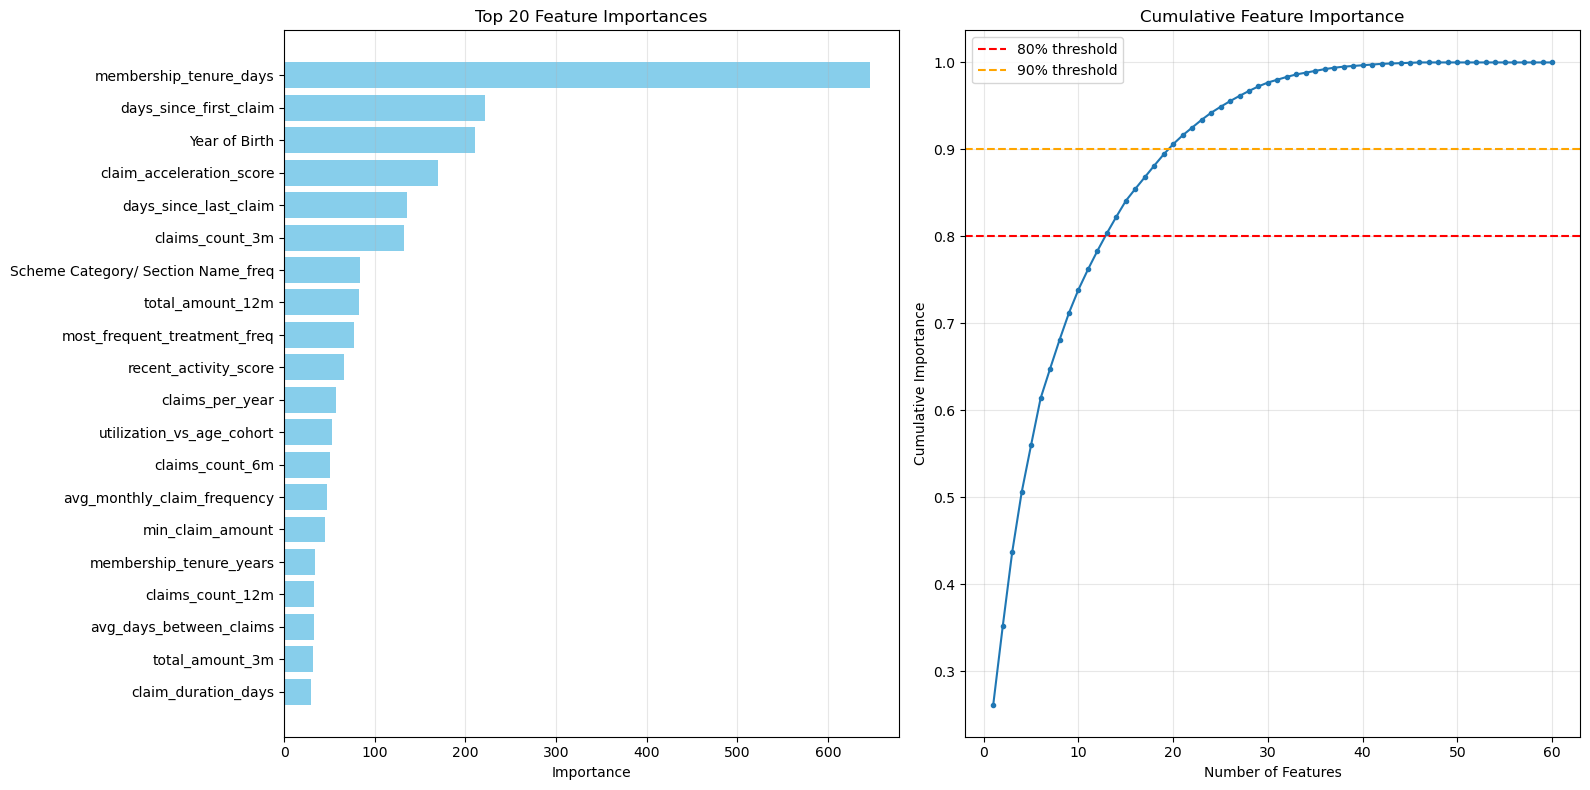


=== FEATURE IMPORTANCE SUMMARY ===
Total features: 60
Features for 80% importance: 12
Features for 90% importance: 19


In [173]:
def analyze_feature_importance_v2(model, X_train_used, top_n=20):
    """
    Robust feature importance analysis
    """
    
    # Get feature importance
    try:
        importance = model.feature_importances_
    except AttributeError:
        print("Model doesn't have feature_importances_ attribute")
        return None
    
    # Get column names
    if hasattr(X_train_used, 'columns'):
        feature_names = X_train_used.columns.tolist()
    elif hasattr(model, 'feature_name_'):
        # For LightGBM
        feature_names = model.feature_name_
    elif hasattr(model, 'get_booster'):
        # For XGBoost
        feature_names = model.get_booster().feature_names
    else:
        # Fallback to indices
        feature_names = [f'feature_{i}' for i in range(len(importance))]
    
    print(f"Model has {len(importance)} feature importances")
    print(f"Found {len(feature_names)} feature names")
    
    # Ensure lengths match
    if len(importance) != len(feature_names):
        print(f"\n⚠ Length mismatch! Truncating to minimum length...")
        min_len = min(len(importance), len(feature_names))
        importance = importance[:min_len]
        feature_names = feature_names[:min_len]
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    print("\n=== TOP {} FEATURES ===".format(top_n))
    print(feature_importance_df.head(top_n).to_string(index=False))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Bar plot
    top_features = feature_importance_df.head(top_n)
    axes[0].barh(range(len(top_features)), top_features['importance'], color='skyblue')
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features['feature'])
    axes[0].set_xlabel('Importance')
    axes[0].set_title(f'Top {top_n} Feature Importances')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Cumulative importance
    feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum() / feature_importance_df['importance'].sum()
    
    axes[1].plot(range(1, len(feature_importance_df) + 1), 
                 feature_importance_df['cumulative_importance'].values,
                 marker='o', markersize=3)
    axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
    axes[1].set_xlabel('Number of Features')
    axes[1].set_ylabel('Cumulative Importance')
    axes[1].set_title('Cumulative Feature Importance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    n_features_80 = (feature_importance_df['cumulative_importance'] <= 0.8).sum()
    n_features_90 = (feature_importance_df['cumulative_importance'] <= 0.9).sum()
    
    print(f"\n=== FEATURE IMPORTANCE SUMMARY ===")
    print(f"Total features: {len(feature_importance_df)}")
    print(f"Features for 80% importance: {n_features_80}")
    print(f"Features for 90% importance: {n_features_90}")
    
    return feature_importance_df

# Use this version
feature_importance_df = analyze_feature_importance_v2(
    best_model, 
    X_train,
    top_n=20
)

#### 6.2 SHAP Analysis

Computing SHAP values...

Generating SHAP summary plot...


c:\Users\sumit\anaconda3\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


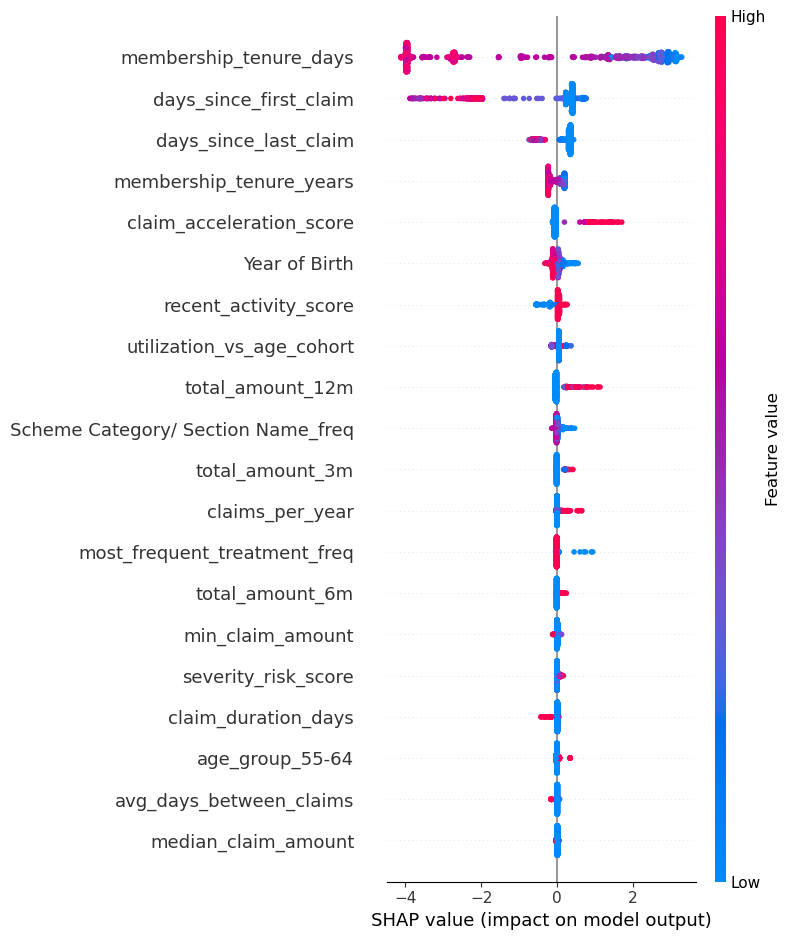


Generating SHAP bar plot...


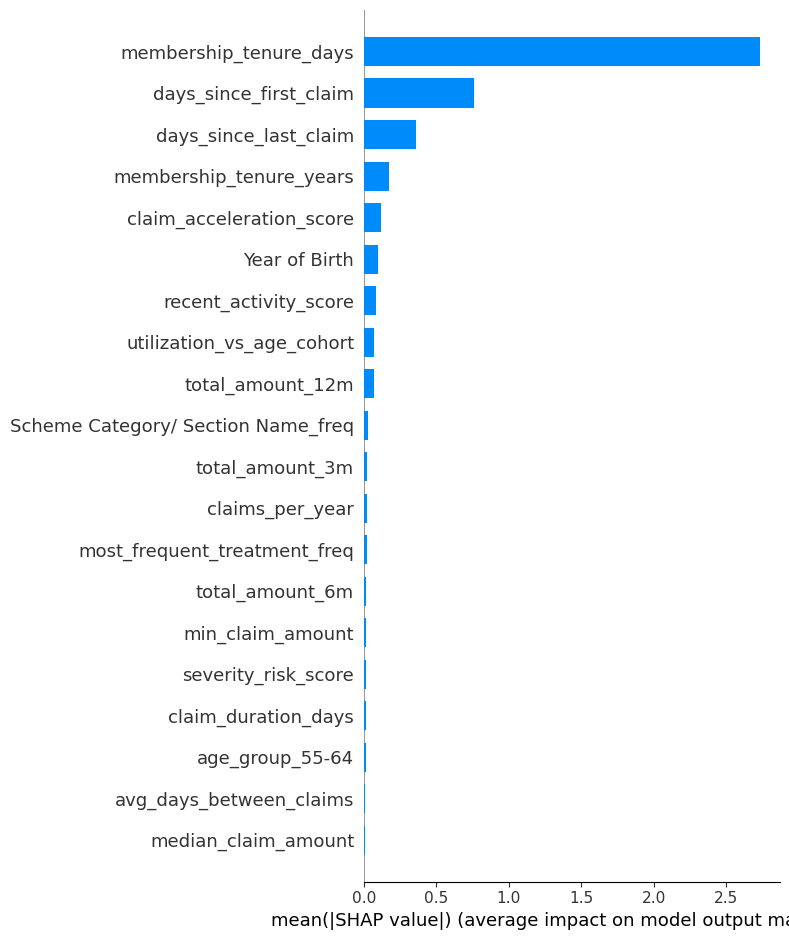


=== TOP FEATURES BY SHAP ===
                               feature  importance
5               membership_tenure_days    2.734497
25              days_since_first_claim    0.761000
26               days_since_last_claim    0.357969
6              membership_tenure_years    0.171035
46            claim_acceleration_score    0.118482
0                        Year of Birth    0.097537
47               recent_activity_score    0.081684
45           utilization_vs_age_cohort    0.067114
22                    total_amount_12m    0.066715
58  Scheme Category/ Section Name_freq    0.026005
18                     total_amount_3m    0.018803
43                     claims_per_year    0.018775
59        most_frequent_treatment_freq    0.018512
20                     total_amount_6m    0.015837
15                    min_claim_amount    0.015442
48                 severity_risk_score    0.013925
27                 claim_duration_days    0.013691
54                     age_group_55-64    0.013587
2

In [174]:
import shap

def perform_shap_analysis(model, X_test, max_display=20):
    """
    SHAP analysis for model interpretability
    """
    
    print("Computing SHAP values...")
    
    # Create explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values (use a sample if dataset is large)
    if len(X_test) > 1000:
        X_sample = X_test.sample(n=1000, random_state=42)
    else:
        X_sample = X_test
    
    shap_values = explainer.shap_values(X_sample)
    
    # If binary classification, SHAP returns values for both classes
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    # === 1. SUMMARY PLOT ===
    print("\nGenerating SHAP summary plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, max_display=max_display, show=False)
    plt.tight_layout()
    plt.show()
    
    # === 2. BAR PLOT ===
    print("\nGenerating SHAP bar plot...")
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=max_display, show=False)
    plt.tight_layout()
    plt.show()
    
    # === 3. FEATURE IMPORTANCE FROM SHAP ===
    shap_importance = pd.DataFrame({
        'feature': X_sample.columns,
        'importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('importance', ascending=False)
    
    print("\n=== TOP FEATURES BY SHAP ===")
    print(shap_importance.head(20))
    
    return shap_values, shap_importance

shap_values, shap_importance = perform_shap_analysis(best_model, X_test)

#### 6.3 Individual Prediction Explanation

=== COMPUTING SHAP VALUES ===

Sampling 1000 observations from 24000 total...
Computing SHAP values for 1000 observations...
SHAP values shape: (1000, 60)

INDIVIDUAL PREDICTION EXPLANATIONS


EXAMPLE 1/5: Member ID: 41726
Predicted Risk Probability: 0.9566
Actual At-Risk Status: NO

Top 10 Contributing Features:
--------------------------------------------------------------------------------
Feature                        Value           SHAP Value      Impact
--------------------------------------------------------------------------------
membership_tenure_days         991.0                 2.2770   ↑ Increases Risk
claim_acceleration_score       0.002159654455287154       1.0178   ↑ Increases Risk
days_since_first_claim         221.0                 0.7413   ↑ Increases Risk
Year of Birth                  1958.0                0.5560   ↑ Increases Risk
total_amount_12m               25832.21              0.4454   ↑ Increases Risk
claims_per_year                1.7773290187586674    

c:\Users\sumit\anaconda3\Lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


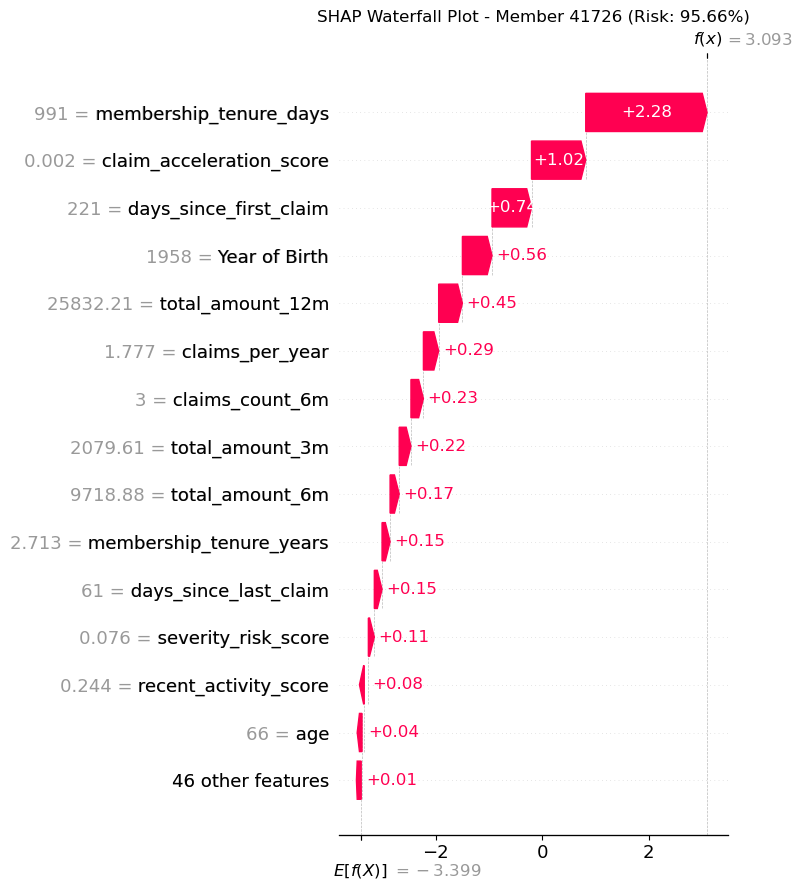


EXAMPLE 2/5: Member ID: 80906
Predicted Risk Probability: 0.9574
Actual At-Risk Status: NO

Top 10 Contributing Features:
--------------------------------------------------------------------------------
Feature                        Value           SHAP Value      Impact
--------------------------------------------------------------------------------
days_since_first_claim         430.0                -2.1164   ↓ Decreases Risk
days_since_last_claim          1.0                   2.0054   ↑ Increases Risk
claim_acceleration_score       0.0021102332288251203       1.6477   ↑ Increases Risk
claims_count_3m                270.0                 1.2239   ↑ Increases Risk
claims_count_12m               1328.0                0.5791   ↑ Increases Risk
total_amount_12m               33612.62062299999       0.5712   ↑ Increases Risk
membership_tenure_days         1308.0                0.5214   ↑ Increases Risk
avg_monthly_claim_frequency    95.86666666666666       0.4824   ↑ Increases Risk
cla

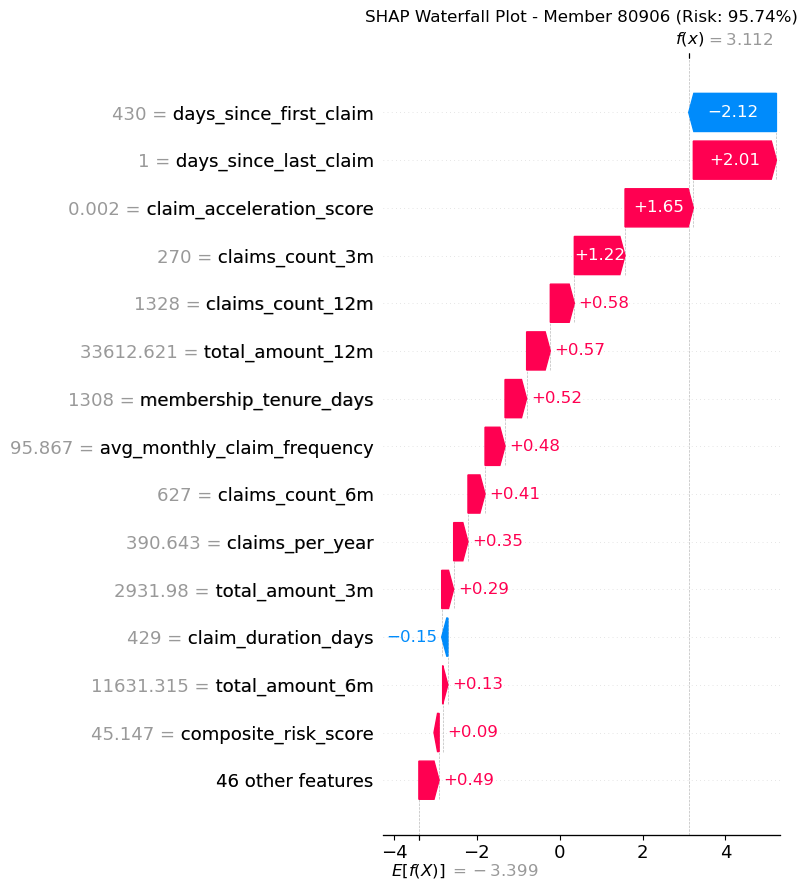


EXAMPLE 3/5: Member ID: 116461
Predicted Risk Probability: 0.9592
Actual At-Risk Status: NO

Top 10 Contributing Features:
--------------------------------------------------------------------------------
Feature                        Value           SHAP Value      Impact
--------------------------------------------------------------------------------
membership_tenure_days         440.0                 2.3869   ↑ Increases Risk
claim_acceleration_score       0.0028795392737162055       1.2348   ↑ Increases Risk
claims_per_year                4.598919259220398       0.5985   ↑ Increases Risk
total_amount_12m               18471.96              0.4430   ↑ Increases Risk
days_since_first_claim         265.0                 0.3744   ↑ Increases Risk
total_amount_3m                2202.35               0.2376   ↑ Increases Risk
claims_count_6m                4.0                   0.2337   ↑ Increases Risk
total_amount_6m                3290.51               0.2006   ↑ Increases Risk
clai

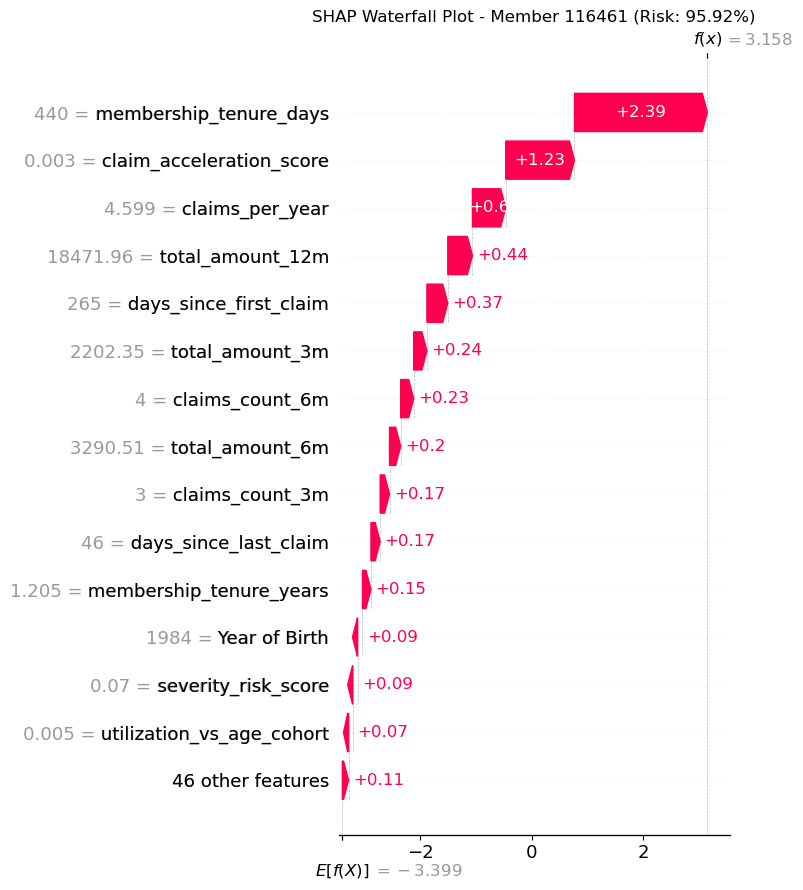


EXAMPLE 4/5: Member ID: 89499
Predicted Risk Probability: 0.9790
Actual At-Risk Status: YES

Top 10 Contributing Features:
--------------------------------------------------------------------------------
Feature                        Value           SHAP Value      Impact
--------------------------------------------------------------------------------
membership_tenure_days         369.0                 2.5874   ↑ Increases Risk
claim_acceleration_score       0.006079027355623099       1.3385   ↑ Increases Risk
days_since_first_claim         173.0                 0.7097   ↑ Increases Risk
claims_per_year                3.6027371925282035       0.5364   ↑ Increases Risk
Year of Birth                  1965.0                0.4645   ↑ Increases Risk
total_amount_12m               18281.86              0.4454   ↑ Increases Risk
total_amount_3m                190.54                0.2436   ↑ Increases Risk
claims_count_6m                4.0                   0.2337   ↑ Increases Risk
tota

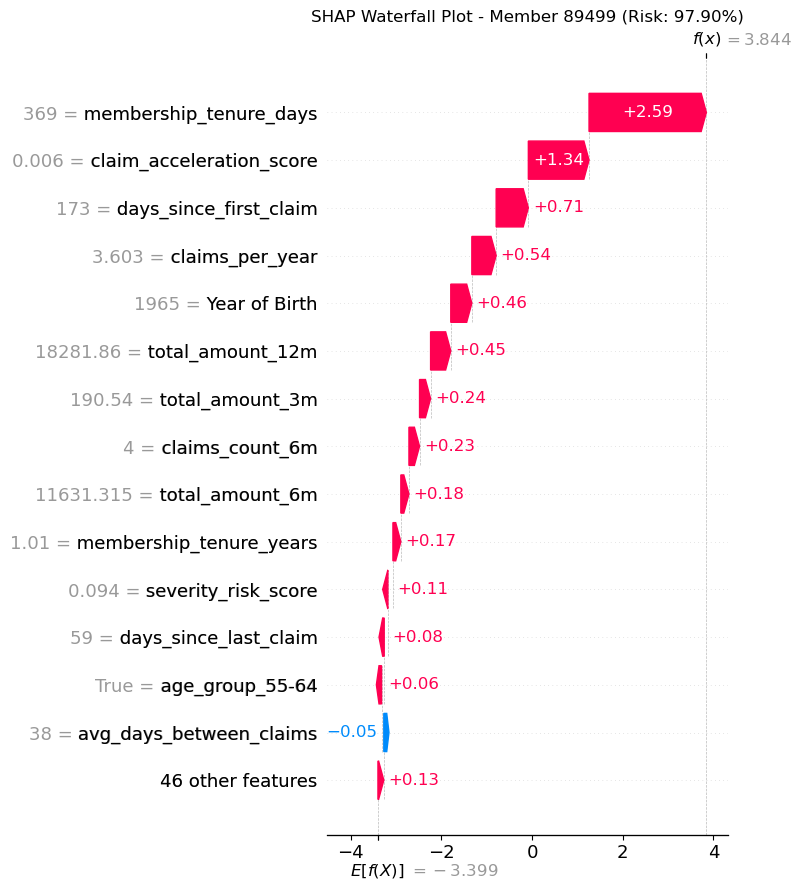


EXAMPLE 5/5: Member ID: 114590
Predicted Risk Probability: 0.9944
Actual At-Risk Status: YES

Top 10 Contributing Features:
--------------------------------------------------------------------------------
Feature                        Value           SHAP Value      Impact
--------------------------------------------------------------------------------
membership_tenure_days         372.0                 2.5521   ↑ Increases Risk
claim_acceleration_score       0.012158054711246199       1.6257   ↑ Increases Risk
days_since_first_claim         139.0                 0.7400   ↑ Increases Risk
claims_per_year                7.152561042775839       0.6335   ↑ Increases Risk
claims_count_6m                8.0                   0.4883   ↑ Increases Risk
total_amount_12m               33612.62062299999       0.4427   ↑ Increases Risk
Year of Birth                  1964.0                0.4061   ↑ Increases Risk
total_amount_3m                2931.9804179999996       0.2858   ↑ Increases Risk

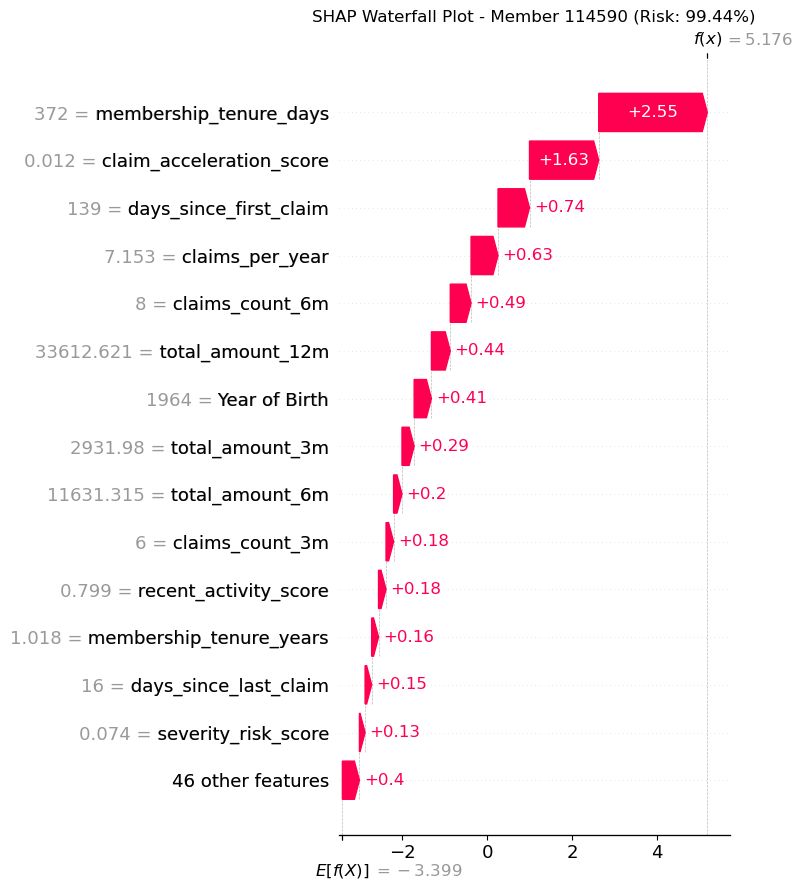

In [175]:
import shap

def explain_individual_predictions_fixed(model, X_test, y_test, n_examples=5, sample_size=1000):
    """
    Explain individual predictions using SHAP with proper indexing
    
    Parameters:
    - model: trained model
    - X_test: test features
    - y_test: test targets
    - n_examples: number of examples to explain
    - sample_size: number of samples to use for SHAP calculation
    """
    
    print("=== COMPUTING SHAP VALUES ===\n")
    
    # Step 1: Sample data if too large
    if len(X_test) > sample_size:
        print(f"Sampling {sample_size} observations from {len(X_test)} total...")
        sample_indices = np.random.choice(X_test.index, size=sample_size, replace=False)
        X_sample = X_test.loc[sample_indices]
        y_sample = y_test.loc[sample_indices]
    else:
        X_sample = X_test
        y_sample = y_test
    
    print(f"Computing SHAP values for {len(X_sample)} observations...")
    
    # Step 2: Create explainer and compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # Handle binary classification (SHAP returns list of arrays)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
        print("Using SHAP values for positive class (at-risk)")
    
    print(f"SHAP values shape: {shap_values.shape}")
    
    # Step 3: Get predictions for the sample
    y_pred_proba = model.predict_proba(X_sample)[:, 1]
    
    # Step 4: Find high-risk predictions
    high_risk_sample_indices = np.argsort(y_pred_proba)[-n_examples:]
    
    print(f"\n{'='*80}")
    print("INDIVIDUAL PREDICTION EXPLANATIONS")
    print(f"{'='*80}\n")
    
    # Step 5: Explain each high-risk prediction
    for i, sample_idx in enumerate(high_risk_sample_indices):
        # Get actual index from X_sample
        actual_member_id = X_sample.index[sample_idx]
        
        print(f"\n{'='*80}")
        print(f"EXAMPLE {i+1}/{n_examples}: Member ID: {actual_member_id}")
        print(f"{'='*80}")
        
        print(f"Predicted Risk Probability: {y_pred_proba[sample_idx]:.4f}")
        print(f"Actual At-Risk Status: {'YES' if y_sample.iloc[sample_idx] == 1 else 'NO'}")
        
        # Get feature values and SHAP values for this instance
        instance_features = X_sample.iloc[sample_idx]
        instance_shap = shap_values[sample_idx]
        
        # Create feature contribution dataframe
        feature_contributions = pd.DataFrame({
            'feature': X_sample.columns,
            'value': instance_features.values,
            'shap_value': instance_shap,
            'abs_shap': np.abs(instance_shap)
        }).sort_values('abs_shap', ascending=False)
        
        print("\nTop 10 Contributing Features:")
        print("-" * 80)
        print(f"{'Feature':<30} {'Value':<15} {'SHAP Value':<15} {'Impact'}")
        print("-" * 80)
        
        for idx, row in feature_contributions.head(10).iterrows():
            impact = "↑ Increases Risk" if row['shap_value'] > 0 else "↓ Decreases Risk"
            print(f"{row['feature']:<30} {str(row['value']):<15} {row['shap_value']:>12.4f}   {impact}")
        
        # Waterfall plot
        try:
            plt.figure(figsize=(10, 6))
            shap.waterfall_plot(
                shap.Explanation(
                    values=instance_shap,
                    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                    data=instance_features.values,
                    feature_names=X_sample.columns.tolist()
                ),
                max_display=15,
                show=False
            )
            plt.title(f'SHAP Waterfall Plot - Member {actual_member_id} (Risk: {y_pred_proba[sample_idx]:.2%})')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not generate waterfall plot: {e}")
    
    return shap_values, X_sample, y_sample

# Use the fixed function
shap_values, X_sample, y_sample = explain_individual_predictions_fixed(
    best_model, 
    X_test, 
    y_test, 
    n_examples=5,
    sample_size=1000
)

#### STEP 7: Causal Analysis & Cohort Exploration
### 7.1 Cohort Segmentation

In [176]:
def create_risk_cohorts(df, predictions_df):
    """
    Segment members into cohorts for analysis with robust handling of edge cases
    """
    
    print("=== CREATING RISK COHORTS ===\n")
    
    # Merge predictions with original data
    df_with_predictions = df.merge(
        predictions_df[['predicted_proba']],
        left_index=True,
        right_index=True,
        how='left'
    )
    
    # If predictions_df has 'decile', add it
    if 'decile' in predictions_df.columns:
        df_with_predictions = df_with_predictions.merge(
            predictions_df[['decile']],
            left_index=True,
            right_index=True,
            how='left'
        )
    
    # Define cohorts dictionary
    cohorts = {}
    
    # === 1. RISK-BASED COHORTS ===
    print("Creating Risk Level cohorts...")
    cohorts['Risk Level'] = pd.cut(
        df_with_predictions['predicted_proba'],
        bins=[0, 0.3, 0.6, 1.0],
        labels=['Low Risk', 'Medium Risk', 'High Risk'],
        include_lowest=True
    )
    
    # === 2. AGE COHORTS ===
    print("Creating Age Group cohorts...")
    if 'age' in df_with_predictions.columns:
        cohorts['Age Group'] = pd.cut(
            df_with_predictions['age'],
            bins=[0, 35, 50, 65, 100],
            labels=['<35', '35-50', '50-65', '65+'],
            include_lowest=True
        )
    else:
        print("⚠ 'age' column not found, skipping Age Group")
    
    # === 3. UTILIZATION COHORTS (with robust handling) ===
    print("Creating Utilization Level cohorts...")
    if 'total_claims_count' in df_with_predictions.columns:
        try:
            # Try qcut first
            cohorts['Utilization Level'] = pd.qcut(
                df_with_predictions['total_claims_count'],
                q=4,
                labels=['Very Low', 'Low', 'Medium', 'High'],
                duplicates='drop'
            )
        except ValueError as e:
            print(f"⚠ qcut failed for utilization, using manual bins: {e}")
            # Fallback to manual percentiles
            percentiles = df_with_predictions['total_claims_count'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
            # Make bins unique
            unique_percentiles = sorted(list(set(percentiles)))
            
            if len(unique_percentiles) >= 3:
                # Create appropriate labels based on actual bins
                n_bins = len(unique_percentiles) - 1
                if n_bins == 4:
                    labels = ['Very Low', 'Low', 'Medium', 'High']
                elif n_bins == 3:
                    labels = ['Low', 'Medium', 'High']
                elif n_bins == 2:
                    labels = ['Low', 'High']
                else:
                    labels = [f'Group {i+1}' for i in range(n_bins)]
                
                cohorts['Utilization Level'] = pd.cut(
                    df_with_predictions['total_claims_count'],
                    bins=unique_percentiles,
                    labels=labels,
                    include_lowest=True
                )
            else:
                # If still not enough unique values, create binary split
                median_val = df_with_predictions['total_claims_count'].median()
                cohorts['Utilization Level'] = df_with_predictions['total_claims_count'].apply(
                    lambda x: 'High' if x > median_val else 'Low'
                )
    else:
        print("⚠ 'total_claims_count' column not found, skipping Utilization Level")
    
    # === 4. COST COHORTS (with robust handling) ===
    print("Creating Cost Level cohorts...")
    if 'total_claim_amount' in df_with_predictions.columns:
        try:
            cohorts['Cost Level'] = pd.qcut(
                df_with_predictions['total_claim_amount'],
                q=4,
                labels=['Very Low', 'Low', 'Medium', 'High'],
                duplicates='drop'
            )
        except ValueError as e:
            print(f"⚠ qcut failed for cost, using manual bins: {e}")
            # Fallback to manual percentiles
            percentiles = df_with_predictions['total_claim_amount'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values
            unique_percentiles = sorted(list(set(percentiles)))
            
            if len(unique_percentiles) >= 3:
                n_bins = len(unique_percentiles) - 1
                if n_bins == 4:
                    labels = ['Very Low', 'Low', 'Medium', 'High']
                elif n_bins == 3:
                    labels = ['Low', 'Medium', 'High']
                elif n_bins == 2:
                    labels = ['Low', 'High']
                else:
                    labels = [f'Group {i+1}' for i in range(n_bins)]
                
                cohorts['Cost Level'] = pd.cut(
                    df_with_predictions['total_claim_amount'],
                    bins=unique_percentiles,
                    labels=labels,
                    include_lowest=True
                )
            else:
                median_val = df_with_predictions['total_claim_amount'].median()
                cohorts['Cost Level'] = df_with_predictions['total_claim_amount'].apply(
                    lambda x: 'High' if x > median_val else 'Low'
                )
    else:
        print("⚠ 'total_claim_amount' column not found, skipping Cost Level")
    
    # === 5. CHRONIC CONDITION COHORTS ===
    print("Creating Chronic Condition cohorts...")
    if 'has_high_risk_condition_history' in df_with_predictions.columns:
        cohorts['Has Chronic Condition'] = (
            df_with_predictions['has_high_risk_condition_history'] == 1
        ).map({True: 'Yes', False: 'No'})
    else:
        print("⚠ 'has_high_risk_condition_history' column not found, skipping")
    
    # === 6. GENDER COHORTS (if available) ===
    if 'Gender' in df_with_predictions.columns:
        cohorts['Gender'] = df_with_predictions['Gender']
    elif 'is_male' in df_with_predictions.columns:
        cohorts['Gender'] = df_with_predictions['is_male'].map({1: 'Male', 0: 'Female'})
    
    # Add cohorts to dataframe
    for cohort_name, cohort_values in cohorts.items():
        df_with_predictions[cohort_name] = cohort_values
    
    print(f"\n✓ Created {len(cohorts)} cohort dimensions")
    print("\nCohort Summary:")
    for cohort_name in cohorts.keys():
        n_categories = df_with_predictions[cohort_name].nunique()
        print(f"  - {cohort_name}: {n_categories} categories")
    
    return df_with_predictions, cohorts

# Apply
df_with_cohorts, cohorts = create_risk_cohorts(processed_df, results_df)

=== CREATING RISK COHORTS ===

Creating Risk Level cohorts...
Creating Age Group cohorts...
Creating Utilization Level cohorts...
⚠ qcut failed for utilization, using manual bins: Bin labels must be one fewer than the number of bin edges
Creating Cost Level cohorts...
⚠ qcut failed for cost, using manual bins: Bin labels must be one fewer than the number of bin edges
Creating Chronic Condition cohorts...

✓ Created 5 cohort dimensions

Cohort Summary:
  - Risk Level: 3 categories
  - Age Group: 4 categories
  - Utilization Level: 2 categories
  - Cost Level: 2 categories
  - Has Chronic Condition: 2 categories


In [177]:
def create_risk_cohorts_simple(df, predictions_df):
    """
    Simplified cohort creation that avoids qcut issues
    """
    
    # Merge predictions
    df_cohorts = df.copy()
    df_cohorts['predicted_proba'] = df_cohorts.index.map(
        predictions_df.set_index(predictions_df.index)['predicted_proba']
    )
    
    # === 1. Risk Level (using percentiles) ===
    df_cohorts['Risk Level'] = 'Low Risk'
    p70 = df_cohorts['predicted_proba'].quantile(0.70)
    p90 = df_cohorts['predicted_proba'].quantile(0.90)
    
    df_cohorts.loc[df_cohorts['predicted_proba'] >= p70, 'Risk Level'] = 'Medium Risk'
    df_cohorts.loc[df_cohorts['predicted_proba'] >= p90, 'Risk Level'] = 'High Risk'
    
    # === 2. Age Groups ===
    if 'age' in df_cohorts.columns:
        df_cohorts['Age Group'] = pd.cut(
            df_cohorts['age'],
            bins=[0, 35, 50, 65, 100],
            labels=['<35', '35-50', '50-65', '65+'],
            include_lowest=True
        )
    
    # === 3. Utilization (using percentile ranks) ===
    if 'total_claims_count' in df_cohorts.columns:
        # Use rank percentile
        df_cohorts['utilization_percentile'] = df_cohorts['total_claims_count'].rank(pct=True)
        
        df_cohorts['Utilization Level'] = 'Very Low'
        df_cohorts.loc[df_cohorts['utilization_percentile'] >= 0.25, 'Utilization Level'] = 'Low'
        df_cohorts.loc[df_cohorts['utilization_percentile'] >= 0.50, 'Utilization Level'] = 'Medium'
        df_cohorts.loc[df_cohorts['utilization_percentile'] >= 0.75, 'Utilization Level'] = 'High'
    
    # === 4. Cost (using percentile ranks) ===
    if 'total_claim_amount' in df_cohorts.columns:
        df_cohorts['cost_percentile'] = df_cohorts['total_claim_amount'].rank(pct=True)
        
        df_cohorts['Cost Level'] = 'Very Low'
        df_cohorts.loc[df_cohorts['cost_percentile'] >= 0.25, 'Cost Level'] = 'Low'
        df_cohorts.loc[df_cohorts['cost_percentile'] >= 0.50, 'Cost Level'] = 'Medium'
        df_cohorts.loc[df_cohorts['cost_percentile'] >= 0.75, 'Cost Level'] = 'High'
    
    # === 5. Chronic Condition ===
    if 'has_high_risk_condition_history' in df_cohorts.columns:
        df_cohorts['Has Chronic Condition'] = df_cohorts['has_high_risk_condition_history'].map({
            1: 'Yes',
            0: 'No'
        })
    
    print("✓ Cohorts created successfully")
    print("\nCohort Distribution:")
    for col in ['Risk Level', 'Age Group', 'Utilization Level', 'Cost Level', 'Has Chronic Condition']:
        if col in df_cohorts.columns:
            print(f"\n{col}:")
            print(df_cohorts[col].value_counts())
    
    return df_cohorts

# Use simple version
df_with_cohorts = create_risk_cohorts_simple(processed_df, results_df)

✓ Cohorts created successfully

Cohort Distribution:

Risk Level:
Risk Level
Low Risk       112799
Medium Risk      4790
High Risk        2411
Name: count, dtype: int64

Age Group:
Age Group
<35      60443
35-50    40900
50-65    16948
65+       1709
Name: count, dtype: int64

Utilization Level:
Utilization Level
Low     87143
High    32857
Name: count, dtype: int64

Cost Level:
Cost Level
Low       87143
High      30001
Medium     2856
Name: count, dtype: int64

Has Chronic Condition:
Has Chronic Condition
No     107480
Yes     12520
Name: count, dtype: int64


#### 7.2 Cohort Analysis

=== COHORT ANALYSIS ===


--- Risk Level ---
              Count  Actual Risk Rate  Predicted Risk Prob  Avg Total Cost  \
Risk Level                                                                   
High Risk      2411            0.0191               0.7607       4390.6084   
Low Risk     112799            0.0197               0.1157       4061.6801   
Medium Risk    4790            0.0207               0.5996       4099.6533   

             Avg Claims  Avg Age  % of Population  
Risk Level                                         
High Risk        1.7263  35.3443             2.01  
Low Risk         1.2245  35.0695            94.00  
Medium Risk      1.2056  35.5211             3.99  


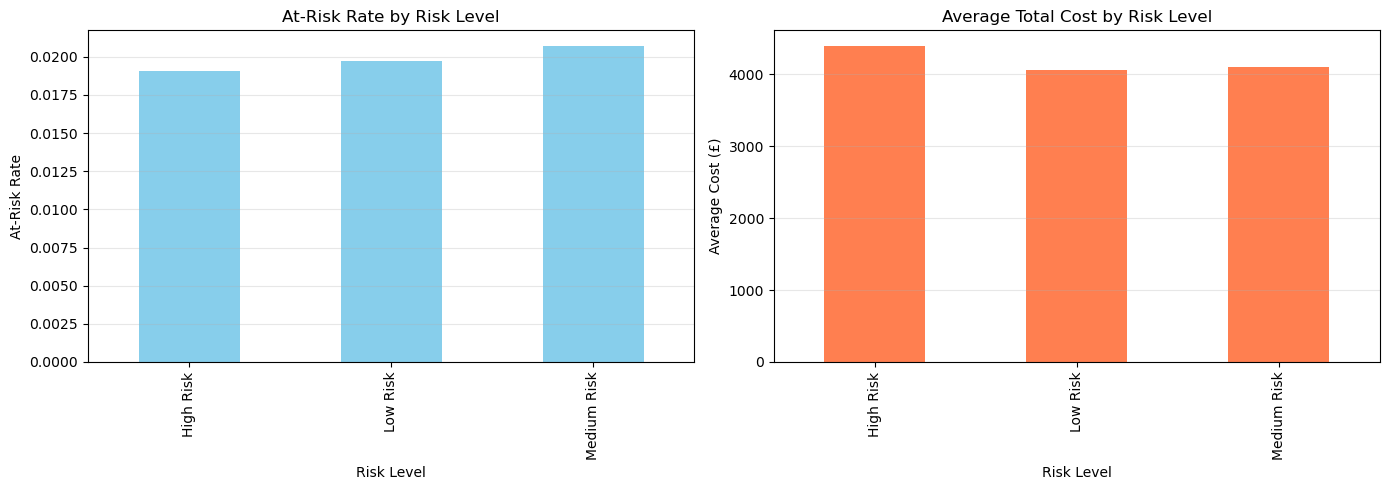


--- Age Group ---
           Count  Actual Risk Rate  Predicted Risk Prob  Avg Total Cost  \
Age Group                                                                 
<35        60443            0.0150               0.2740       2857.9235   
35-50      40900            0.0212               0.2773       4677.7924   
50-65      16948            0.0299               0.2867       6231.5459   
65+         1709            0.0503               0.2800      10942.7347   

           Avg Claims  Avg Age  % of Population  
Age Group                                        
<35            0.8585  23.0659            50.37  
35-50          1.5034  42.7808            34.08  
50-65          1.7344  55.9242            14.12  
65+            3.0884  69.8988             1.42  


C:\Temp\ipykernel_15380\4239428755.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df_with_cohorts.groupby(cohort_col).agg({


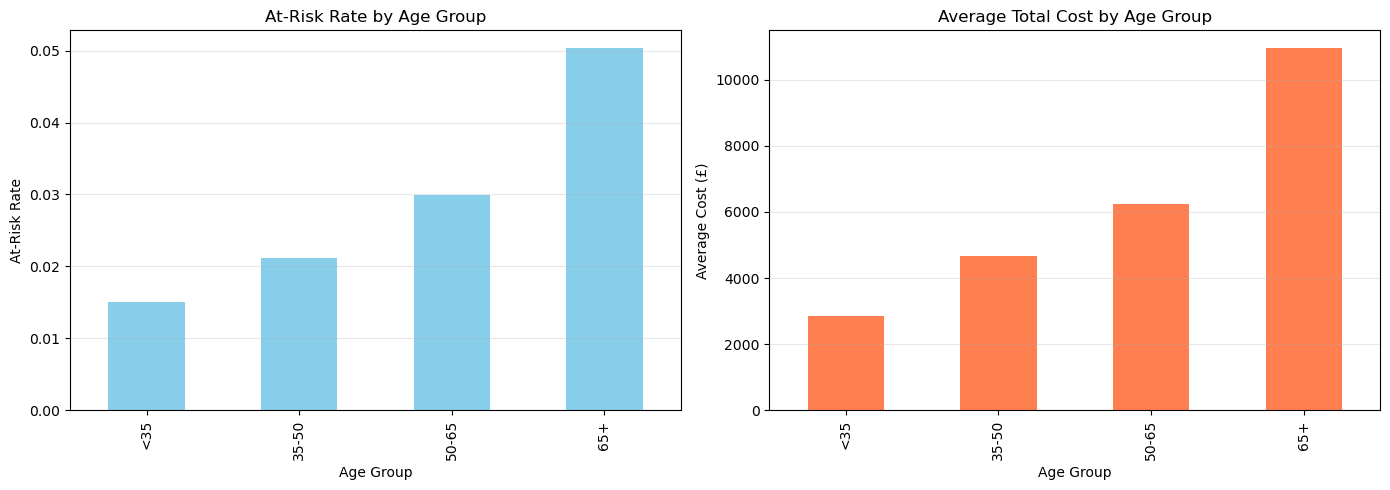


--- Utilization Level ---
                   Count  Actual Risk Rate  Predicted Risk Prob  \
Utilization Level                                                 
High               32857            0.0306               0.2791   
Low                87143            0.0156               0.2763   

                   Avg Total Cost  Avg Claims  Avg Age  % of Population  
Utilization Level                                                        
High                   14863.6988       4.506  35.2320            27.38  
Low                        0.0000       0.000  35.0407            72.62  


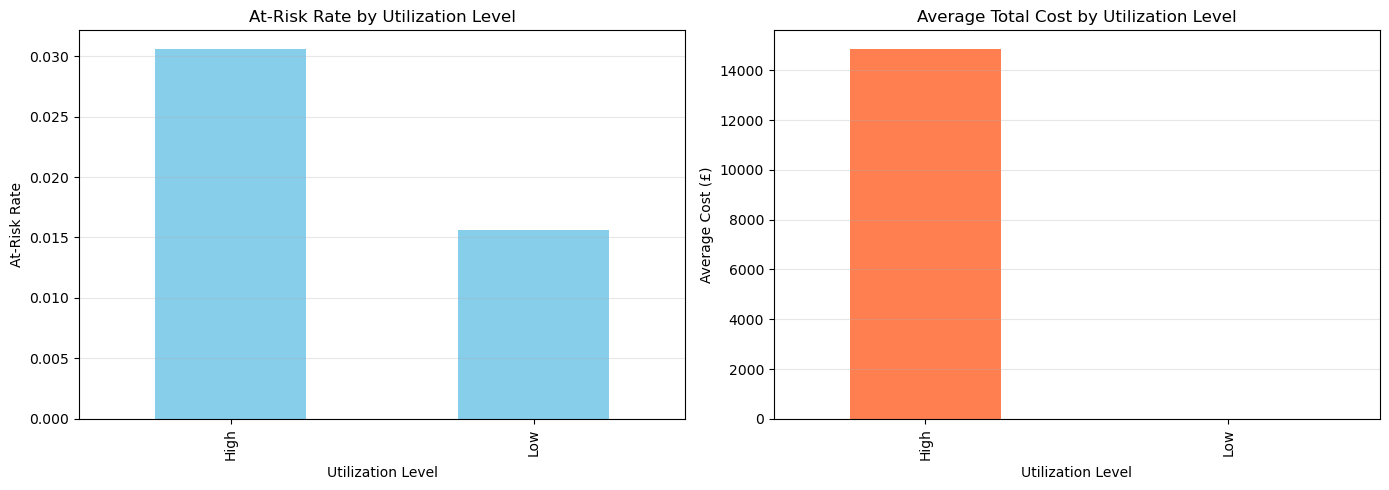


--- Cost Level ---
            Count  Actual Risk Rate  Predicted Risk Prob  Avg Total Cost  \
Cost Level                                                                 
High        30001            0.0319               0.2806      16260.9216   
Low         87143            0.0156               0.2763          0.0000   
Medium       2856            0.0179               0.2623        186.4994   

            Avg Claims  Avg Age  % of Population  
Cost Level                                        
High            4.8393  35.6859            25.00  
Low             0.0000  35.0407            72.62  
Medium          1.0053  30.4636             2.38  


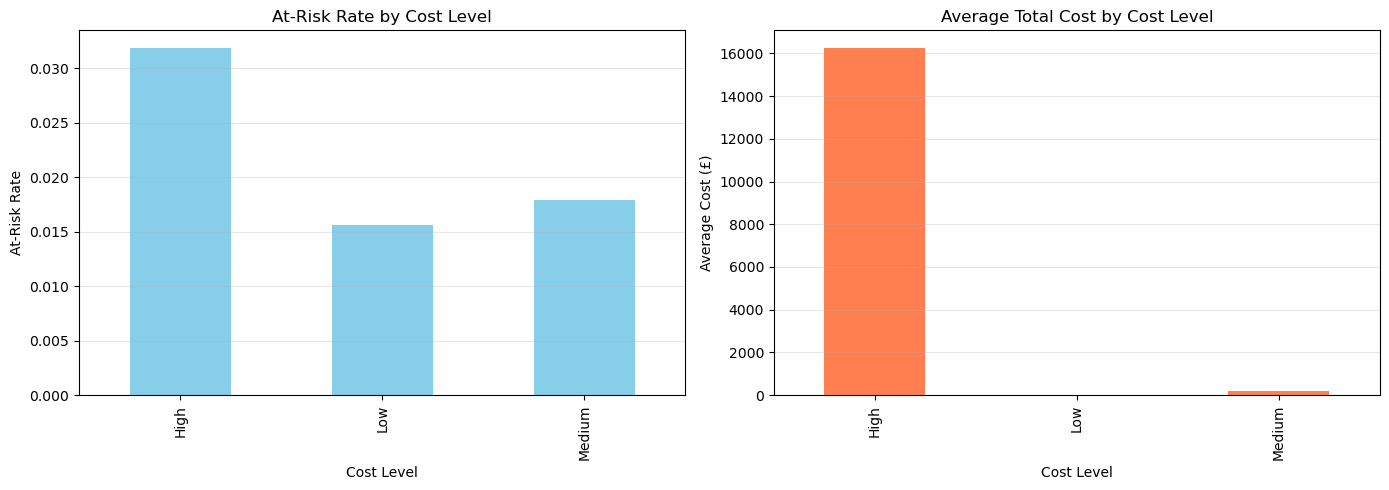


--- Has Chronic Condition ---
                        Count  Actual Risk Rate  Predicted Risk Prob  \
Has Chronic Condition                                                  
No                     107480            0.0173               0.2770   
Yes                     12520            0.0407               0.2777   

                       Avg Total Cost  Avg Claims  Avg Age  % of Population  
Has Chronic Condition                                                        
No                          1608.7962      0.3042  34.7412            89.57  
Yes                        25196.7359      9.2138  38.1137            10.43  


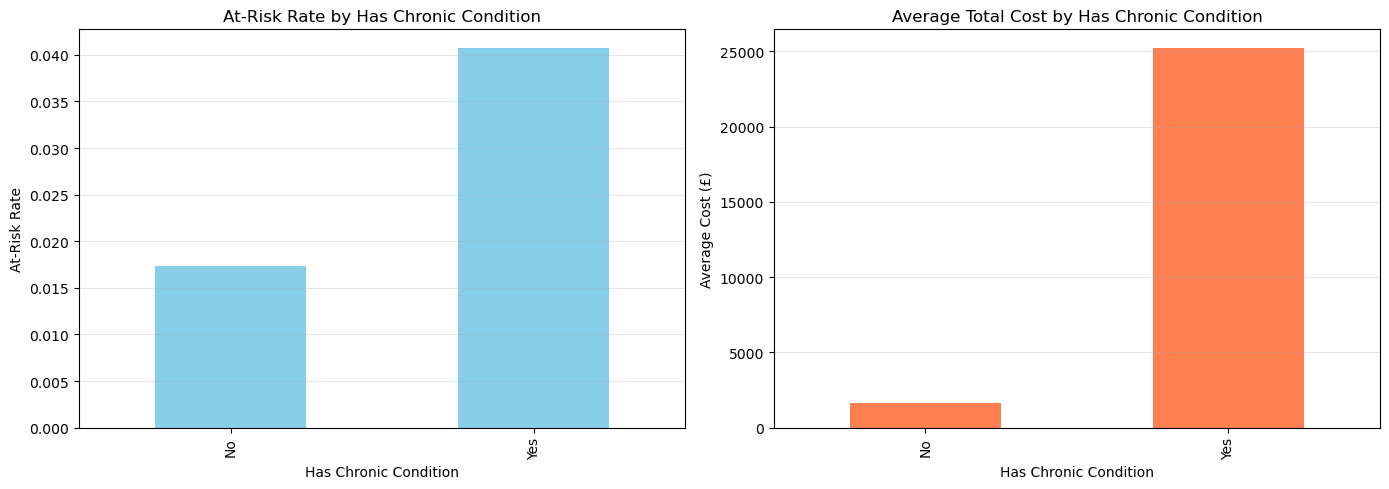

In [178]:
def analyze_cohorts(df_with_cohorts):
    """
    Analyze risk patterns across cohorts
    """
    
    cohort_columns = [
        'Risk Level', 'Age Group', 'Utilization Level', 
        'Cost Level', 'Has Chronic Condition'
    ]
    
    print("=== COHORT ANALYSIS ===\n")
    
    for cohort_col in cohort_columns:
        print(f"\n--- {cohort_col} ---")
        
        analysis = df_with_cohorts.groupby(cohort_col).agg({
            'Unique ID': 'count',
            'is_at_risk': 'mean',
            'predicted_proba': 'mean',
            'total_claim_amount': 'mean',
            'total_claims_count': 'mean',
            'age': 'mean'
        }).round(4)
        
        analysis.columns = [
            'Count', 'Actual Risk Rate', 'Predicted Risk Prob',
            'Avg Total Cost', 'Avg Claims', 'Avg Age'
        ]
        
        analysis['% of Population'] = (analysis['Count'] / analysis['Count'].sum() * 100).round(2)
        
        print(analysis)
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Risk rate by cohort
        analysis['Actual Risk Rate'].plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title(f'At-Risk Rate by {cohort_col}')
        axes[0].set_ylabel('At-Risk Rate')
        axes[0].set_xlabel(cohort_col)
        axes[0].grid(axis='y', alpha=0.3)
        
        # Average cost by cohort
        analysis['Avg Total Cost'].plot(kind='bar', ax=axes[1], color='coral')
        axes[1].set_title(f'Average Total Cost by {cohort_col}')
        axes[1].set_ylabel('Average Cost (£)')
        axes[1].set_xlabel(cohort_col)
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

analyze_cohorts(df_with_cohorts)

#### 7.3 Cross-Cohort Analysis

=== CROSS-COHORT ANALYSIS ===

--- Age Group x Risk Level ---
Risk Level  High Risk  Low Risk  Medium Risk
Age Group                                   
<35           2539.25   2862.96      2897.77
35-50         4963.19   4689.43      4254.33
50-65         7955.00   6190.51      6260.06
65+          18938.34  10540.25     15668.57


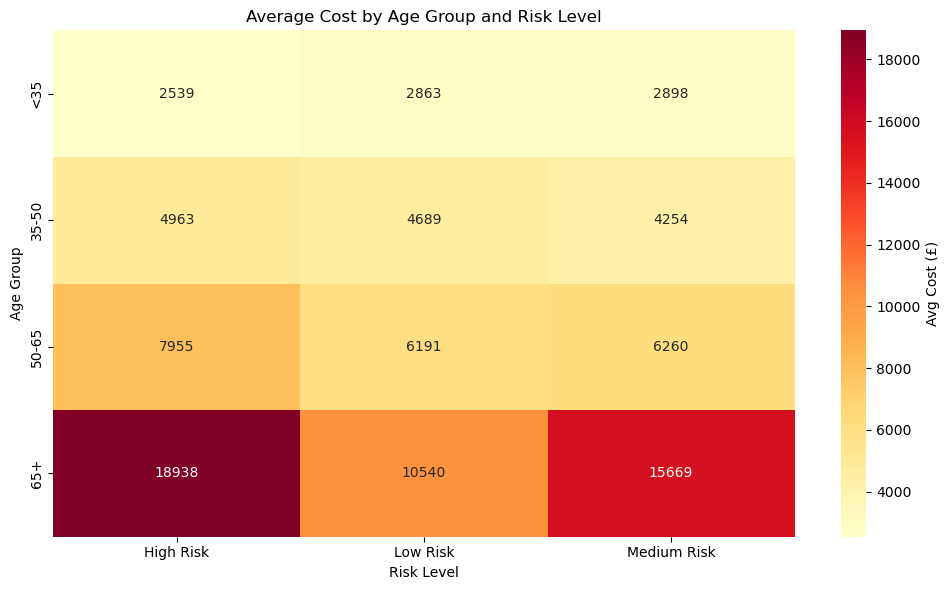


--- Utilization Level x Has Chronic Condition ---
Has Chronic Condition      No     Yes
Utilization Level                    
High                   0.0245  0.0407
Low                    0.0156     NaN


<Figure size 800x600 with 0 Axes>

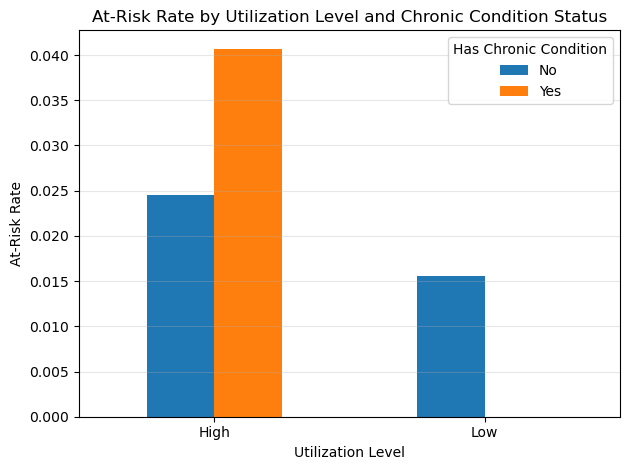

In [179]:
def cross_cohort_analysis(df_with_cohorts):
    """
    Analyze interactions between cohorts
    """
    
    print("=== CROSS-COHORT ANALYSIS ===\n")
    
    # Age vs Risk Level
    print("--- Age Group x Risk Level ---")
    cross_tab1 = pd.crosstab(
        df_with_cohorts['Age Group'],
        df_with_cohorts['Risk Level'],
        values=df_with_cohorts['total_claim_amount'],
        aggfunc='mean'
    ).round(2)
    
    print(cross_tab1)
    
    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cross_tab1, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Avg Cost (£)'})
    plt.title('Average Cost by Age Group and Risk Level')
    plt.tight_layout()
    plt.show()
    
    # Utilization vs Has Chronic Condition
    print("\n--- Utilization Level x Has Chronic Condition ---")
    cross_tab2 = pd.crosstab(
        df_with_cohorts['Utilization Level'],
        df_with_cohorts['Has Chronic Condition'],
        values=df_with_cohorts['is_at_risk'],
        aggfunc='mean'
    ).round(4)
    
    print(cross_tab2)
    
    plt.figure(figsize=(8, 6))
    cross_tab2.plot(kind='bar', rot=0)
    plt.title('At-Risk Rate by Utilization Level and Chronic Condition Status')
    plt.ylabel('At-Risk Rate')
    plt.xlabel('Utilization Level')
    plt.legend(title='Has Chronic Condition')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

cross_cohort_analysis(df_with_cohorts)

#### 7.4 Root Cause Analysis

=== ROOT CAUSE ANALYSIS ===

Key Differences between High-Risk and Low-Risk Members:
                 Feature  High Risk Mean  Low Risk Mean  Difference  % Difference
         claims_count_6m        0.421817       0.165001    0.256815        155.64
      total_claims_count        1.726255       1.224452    0.501802         40.98
  high_cost_claims_count        0.201991       0.179505    0.022486         12.53
      total_claim_amount     4390.608445    4061.680105  328.928340          8.10
  unique_condition_codes        0.767731       0.720831    0.046900          6.51
        avg_claim_amount     1151.205487    1107.659348   43.546139          3.93
claim_acceleration_score        0.000143       0.000140    0.000003          2.34
 membership_tenure_years        3.429949       3.403009    0.026940          0.79
                     age       35.344255      35.069540    0.274716          0.78
   days_since_last_claim      170.885939     170.804325    0.081615          0.05


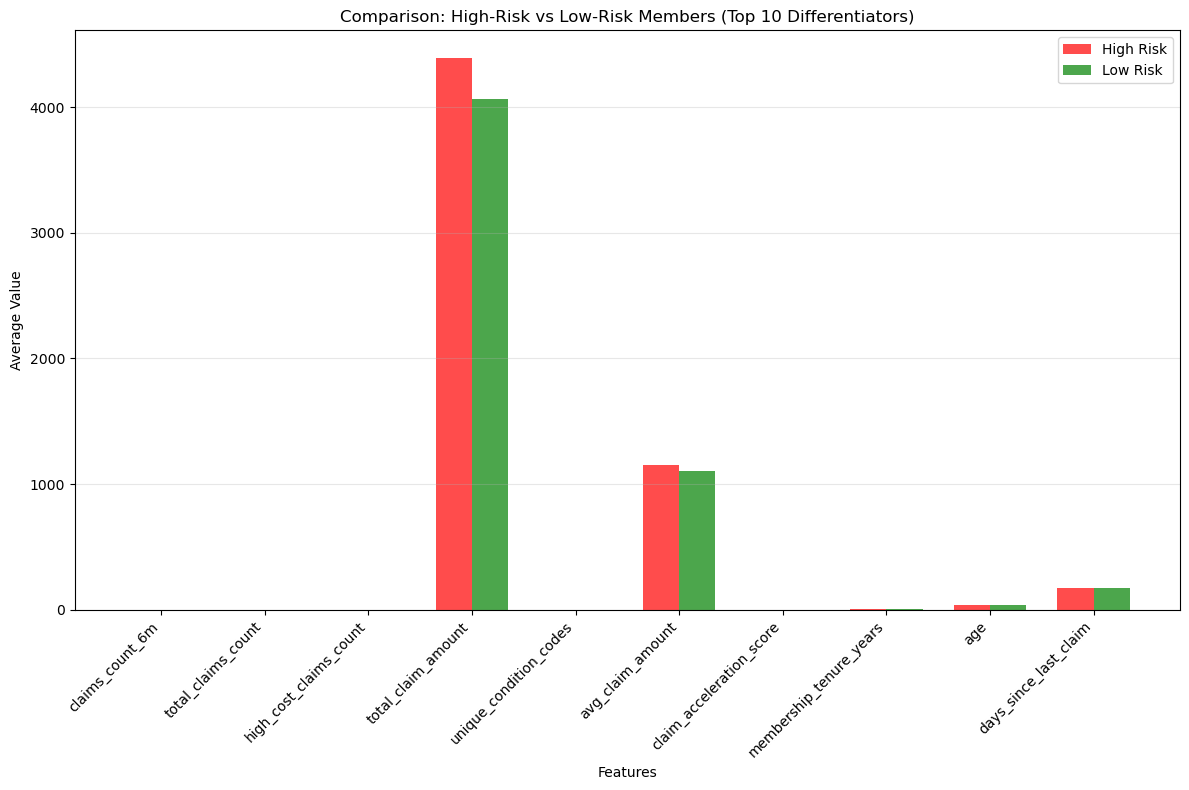


--- Statistical Significance (t-test) ---
                 Feature  t-statistic  p-value Significant
         claims_count_6m     2.865627 0.004163         Yes
  high_cost_claims_count     1.809467 0.070381          No
      total_claims_count     1.277772 0.201333          No
  unique_condition_codes     1.061841 0.288310          No
                     age     0.952847 0.340670          No
      total_claim_amount     0.903454 0.366287          No
 membership_tenure_years     0.777550 0.436836          No
        avg_claim_amount     0.511850 0.608757          No
claim_acceleration_score     0.046499 0.962913          No
   days_since_last_claim     0.011312 0.990975          No


In [180]:
def root_cause_analysis(df_with_cohorts):
    """
    Identify key drivers of high risk
    """
    
    print("=== ROOT CAUSE ANALYSIS ===\n")
    
    # Separate high-risk and low-risk members
    high_risk = df_with_cohorts[df_with_cohorts['Risk Level'] == 'High Risk']
    low_risk = df_with_cohorts[df_with_cohorts['Risk Level'] == 'Low Risk']
    
    # Compare characteristics
    numerical_features = [
        'age', 'membership_tenure_years', 'total_claims_count',
        'total_claim_amount', 'avg_claim_amount', 'claims_count_6m',
        'high_cost_claims_count', 'unique_condition_codes',
        'days_since_last_claim', 'claim_acceleration_score'
    ]
    
    comparison = pd.DataFrame({
        'Feature': numerical_features,'High Risk Mean': [high_risk[f].mean() for f in numerical_features],
        'Low Risk Mean': [low_risk[f].mean() for f in numerical_features],
    })
    
    comparison['Difference'] = comparison['High Risk Mean'] - comparison['Low Risk Mean']
    comparison['% Difference'] = (
        (comparison['High Risk Mean'] - comparison['Low Risk Mean']) / 
        comparison['Low Risk Mean'] * 100
    ).round(2)
    
    comparison = comparison.sort_values('% Difference', ascending=False, key=abs)
    
    print("Key Differences between High-Risk and Low-Risk Members:")
    print(comparison.to_string(index=False))
    
    # Visualize top differences
    plt.figure(figsize=(12, 8))
    
    top_10_features = comparison.head(10)
    
    x = np.arange(len(top_10_features))
    width = 0.35
    
    plt.bar(x - width/2, top_10_features['High Risk Mean'], width, label='High Risk', color='red', alpha=0.7)
    plt.bar(x + width/2, top_10_features['Low Risk Mean'], width, label='Low Risk', color='green', alpha=0.7)
    
    plt.xlabel('Features')
    plt.ylabel('Average Value')
    plt.title('Comparison: High-Risk vs Low-Risk Members (Top 10 Differentiators)')
    plt.xticks(x, top_10_features['Feature'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # === Statistical significance testing ===
    from scipy.stats import ttest_ind
    
    print("\n--- Statistical Significance (t-test) ---")
    
    significance_results = []
    
    for feature in numerical_features:
        high_risk_values = high_risk[feature].dropna()
        low_risk_values = low_risk[feature].dropna()
        
        if len(high_risk_values) > 0 and len(low_risk_values) > 0:
            t_stat, p_value = ttest_ind(high_risk_values, low_risk_values)
            
            significance_results.append({
                'Feature': feature,
                't-statistic': t_stat,
                'p-value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
    
    significance_df = pd.DataFrame(significance_results).sort_values('p-value')
    print(significance_df.head(15).to_string(index=False))
    
    return comparison, significance_df

comparison_df, significance_df = root_cause_analysis(df_with_cohorts)

#### STEP 8: Risk Stratification & Member Scoring
### 8.1 Create Risk Score System

=== RISK SCORING DISTRIBUTION ===
Risk_Category
Low         13569
Medium       1472
High         7586
Critical     1335
Name: count, dtype: int64

Average Risk Score: 27.71
Median Risk Score: 13.30


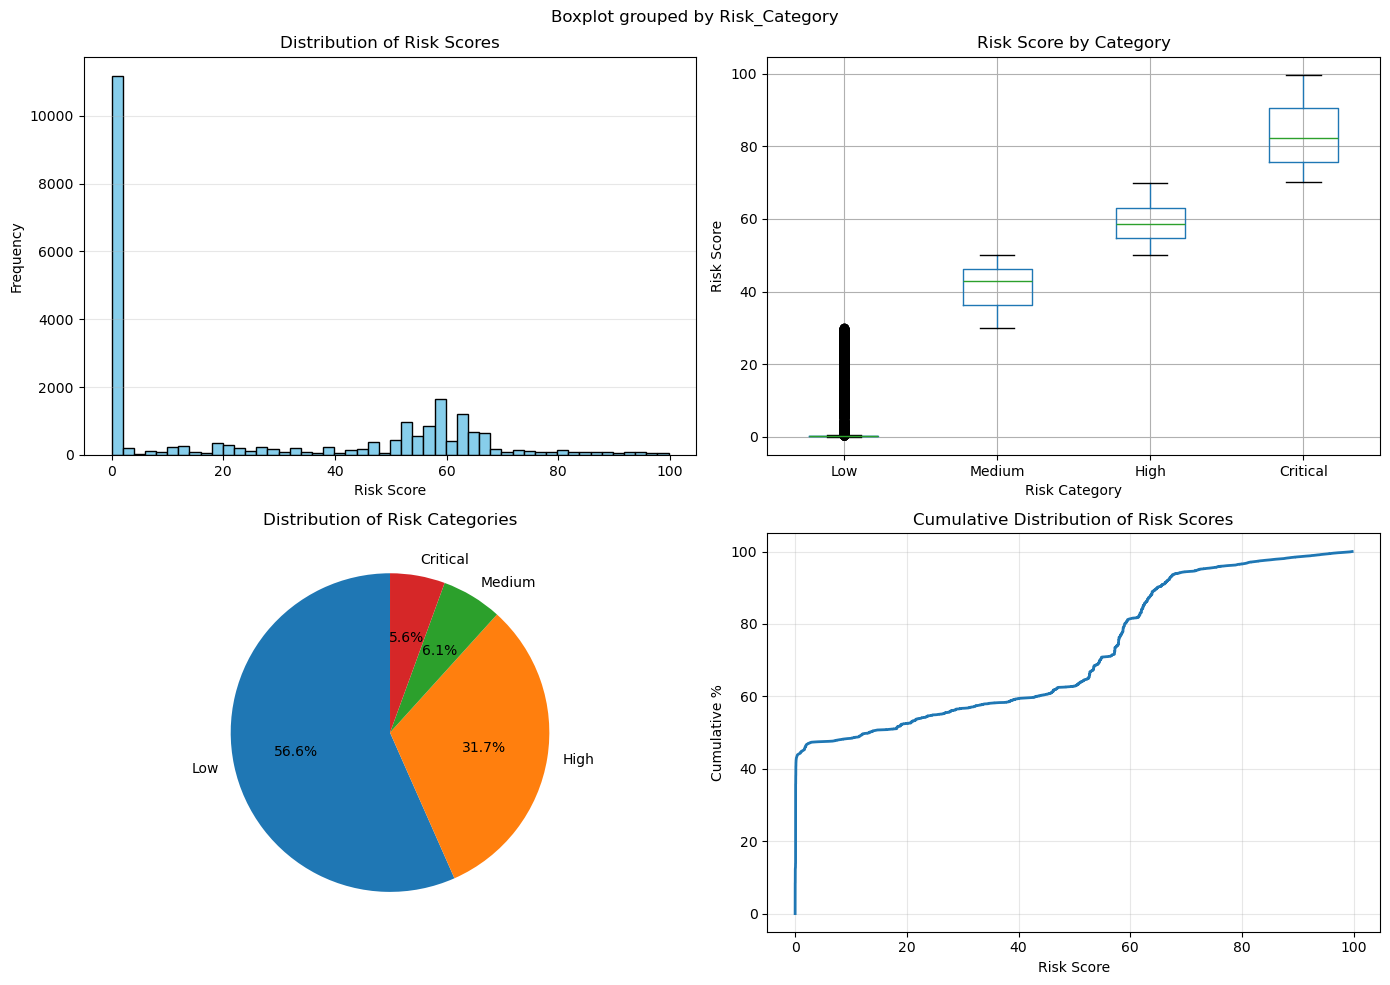

In [181]:
def create_risk_scoring_system(model, X, feature_names):
    """
    Create a risk scoring system for members
    """
    
    # Get predictions
    risk_probabilities = model.predict_proba(X)[:, 1]
    
    # Create risk scores (0-100)
    risk_scores = (risk_probabilities * 100).round(2)
    
    # Create risk categories
    risk_categories = pd.cut(
        risk_scores,
        bins=[0, 30, 50, 70, 100],
        labels=['Low', 'Medium', 'High', 'Critical']
    )
    
    # Create scoring dataframe
    scoring_df = pd.DataFrame({
        'Member_ID': X.index,
        'Risk_Score': risk_scores,
        'Risk_Probability': risk_probabilities.round(4),
        'Risk_Category': risk_categories,
        'Risk_Percentile': pd.Series(risk_scores).rank(pct=True).round(4) * 100
    })
    
    print("=== RISK SCORING DISTRIBUTION ===")
    print(scoring_df['Risk_Category'].value_counts().sort_index())
    print(f"\nAverage Risk Score: {risk_scores.mean():.2f}")
    print(f"Median Risk Score: {np.median(risk_scores):.2f}")
    
    # Visualize distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram
    axes[0, 0].hist(risk_scores, bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Risk Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Risk Scores')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Box plot by category
    scoring_df.boxplot(column='Risk_Score', by='Risk_Category', ax=axes[0, 1])
    axes[0, 1].set_title('Risk Score by Category')
    axes[0, 1].set_xlabel('Risk Category')
    axes[0, 1].set_ylabel('Risk Score')
    plt.sca(axes[0, 1])
    plt.xticks(rotation=0)
    
    # Pie chart of categories
    category_counts = scoring_df['Risk_Category'].value_counts()
    axes[1, 0].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Distribution of Risk Categories')
    
    # Cumulative distribution
    sorted_scores = np.sort(risk_scores)
    cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores) * 100
    axes[1, 1].plot(sorted_scores, cumulative, linewidth=2)
    axes[1, 1].set_xlabel('Risk Score')
    axes[1, 1].set_ylabel('Cumulative %')
    axes[1, 1].set_title('Cumulative Distribution of Risk Scores')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return scoring_df

# Create risk scores
risk_scores_df = create_risk_scoring_system(best_model, X_test, selected_features)

#### 8.2 Identify High-Priority Members for Intervention

In [182]:
def identify_intervention_targets(scoring_df, df_with_cohorts, top_n=100):
    """
    Identify members who should receive interventions
    
    Parameters:
    - scoring_df: DataFrame with risk scores (has 'Member_ID' column)
    - df_with_cohorts: DataFrame with member details (has 'Unique ID' as index or column)
    - top_n: Number of top priority members to identify
    """
    
    print(f"=== IDENTIFYING INTERVENTION TARGETS ===\n")
    
    # Check what columns exist
    print("Scoring DataFrame columns:", scoring_df.columns.tolist()[:10])
    print("Cohorts DataFrame columns:", df_with_cohorts.columns.tolist()[:10])
    
    # Identify the member ID column in scoring_df
    if 'Member_ID' in scoring_df.columns:
        member_id_col = 'Member_ID'
    elif 'Unique ID' in scoring_df.columns:
        member_id_col = 'Unique ID'
    else:
        # Use index as member ID
        scoring_df_copy = scoring_df.copy()
        scoring_df_copy['Member_ID'] = scoring_df_copy.index
        member_id_col = 'Member_ID'
        scoring_df = scoring_df_copy
    
    print(f"Using '{member_id_col}' as member identifier")
    
    # Prepare df_with_cohorts for merge
    if 'Unique ID' not in df_with_cohorts.columns:
        df_cohorts_merge = df_with_cohorts.copy()
        df_cohorts_merge['Unique ID'] = df_cohorts_merge.index
    else:
        df_cohorts_merge = df_with_cohorts.copy()
    
    # Select columns that exist in df_with_cohorts
    available_cols = ['Unique ID']
    optional_cols = [
        'age', 'Gender', 'total_claim_amount', 'total_claims_count',
        'has_high_risk_condition_history', 'membership_tenure_years',
        'Scheme Category/ Section Name', 'is_male'
    ]
    
    for col in optional_cols:
        if col in df_cohorts_merge.columns:
            available_cols.append(col)
    
    print(f"Merging on columns: {available_cols}")
    
    # Merge scoring with member details
    intervention_df = scoring_df.merge(
        df_cohorts_merge[available_cols],
        left_on=member_id_col,
        right_on='Unique ID',
        how='left'
    )
    
    print(f"Merged dataframe shape: {intervention_df.shape}")
    
    # Handle Gender column if not present
    if 'Gender' not in intervention_df.columns and 'is_male' in intervention_df.columns:
        intervention_df['Gender'] = intervention_df['is_male'].map({1: 'Male', 0: 'Female', np.nan: 'Unknown'})
    
    # Select high-risk members
    if 'Risk_Category' in intervention_df.columns:
        high_risk_members = intervention_df[
            intervention_df['Risk_Category'].isin(['High', 'Critical'])
        ].sort_values('Risk_Score', ascending=False).head(top_n)
    else:
        # If no Risk_Category, use top scores
        high_risk_members = intervention_df.nlargest(top_n, 'Risk_Score')
    
    print(f"\n=== TOP {top_n} MEMBERS FOR INTERVENTION ===\n")
    total_high_risk = len(intervention_df[intervention_df.get('Risk_Category', intervention_df['Risk_Score'] > 70).isin(['High', 'Critical'])])
    print(f"Total high/critical risk members: {total_high_risk}")
    
    # === SEGMENT BY INTERVENTION TYPE ===
    intervention_df['Intervention_Type'] = 'None'
    
    # Get column availability
    has_cost = 'total_claim_amount' in intervention_df.columns
    has_chronic = 'has_high_risk_condition_history' in intervention_df.columns
    has_claims_count = 'total_claims_count' in intervention_df.columns
    
    # 1. Intensive Case Management (Critical risk)
    intervention_df.loc[
        intervention_df['Risk_Score'] > 90,
        'Intervention_Type'
    ] = 'Intensive Case Management'
    
    # 2. Cost Management (High risk + high historical costs)
    if has_cost:
        cost_threshold = intervention_df['total_claim_amount'].quantile(0.75)
        intervention_df.loc[
            (intervention_df['Risk_Score'] > 70) & 
            (intervention_df['total_claim_amount'] > cost_threshold),
            'Intervention_Type'
        ] = 'Cost Management'
    
    # 3. Disease Management (High risk + chronic condition)
    if has_chronic:
        intervention_df.loc[
            (intervention_df['Risk_Score'] > 70) & 
            (intervention_df['has_high_risk_condition_history'] == 1),
            'Intervention_Type'
        ] = 'Disease Management'
    
    # 4. Preventive Care (Medium/High risk + low utilization)
    if has_claims_count:
        intervention_df.loc[
            (intervention_df['Risk_Score'].between(50, 80)) & 
            (intervention_df['total_claims_count'] < 5),
            'Intervention_Type'
        ] = 'Preventive Care'
    
    print("\n--- Intervention Type Distribution ---")
    print(intervention_df['Intervention_Type'].value_counts())
    
    # Summary statistics
    if len(high_risk_members) > 0:
        summary_cols = ['Unique ID']
        metric_cols = {'Unique ID': 'count', 'Risk_Score': 'mean'}
        
        if has_cost:
            summary_cols.append('total_claim_amount')
            metric_cols['total_claim_amount'] = 'sum'
        if 'age' in intervention_df.columns:
            summary_cols.append('age')
            metric_cols['age'] = 'mean'
        
        priority_summary = high_risk_members.groupby('Intervention_Type').agg(metric_cols).round(2)
        
        # Rename columns
        new_cols = ['Count', 'Avg Risk Score']
        if has_cost:
            new_cols.append('Total Claims (£)')
        if 'age' in intervention_df.columns:
            new_cols.append('Avg Age')
        
        priority_summary.columns = new_cols
        
        print("\n--- High-Priority Members by Intervention Type ---")
        print(priority_summary)
    
    # Create export dataframe
    export_cols = ['Unique ID', 'Risk_Score', 'Intervention_Type']
    
    if 'Risk_Category' in intervention_df.columns:
        export_cols.append('Risk_Category')
    if 'Risk_Percentile' in intervention_df.columns:
        export_cols.append('Risk_Percentile')
    
    for col in ['age', 'Gender', 'total_claim_amount', 'total_claims_count', 'membership_tenure_years']:
        if col in intervention_df.columns:
            export_cols.append(col)
    
    export_df = high_risk_members[export_cols].copy()
    
    print("\n--- Sample of Top 10 Members ---")
    print(export_df.head(10).to_string(index=False))
    
    return intervention_df, export_df

# Apply with error handling
try:
    intervention_df, priority_members = identify_intervention_targets(
        risk_scores_df, 
        df_with_cohorts,
        top_n=100
    )
except Exception as e:
    print(f"Error in intervention targeting: {e}")
    print("\nDebugging information:")
    print(f"risk_scores_df shape: {risk_scores_df.shape}")
    print(f"risk_scores_df columns: {risk_scores_df.columns.tolist()}")
    print(f"df_with_cohorts shape: {df_with_cohorts.shape}")
    print(f"df_with_cohorts has 'Unique ID': {'Unique ID' in df_with_cohorts.columns}")

=== IDENTIFYING INTERVENTION TARGETS ===

Scoring DataFrame columns: ['Member_ID', 'Risk_Score', 'Risk_Probability', 'Risk_Category', 'Risk_Percentile']
Cohorts DataFrame columns: ['Unique ID', 'Year of Birth', 'age', 'gender_Female', 'gender_Male', 'gender_Other', 'membership_tenure_days', 'membership_tenure_years', 'is_active_member', 'Scheme Category/ Section Name']
Using 'Member_ID' as member identifier
Merging on columns: ['Unique ID', 'age', 'total_claim_amount', 'total_claims_count', 'has_high_risk_condition_history', 'membership_tenure_years', 'Scheme Category/ Section Name']
Error in intervention targeting: You are trying to merge on int64 and object columns for key 'Member_ID'. If you wish to proceed you should use pd.concat

Debugging information:
risk_scores_df shape: (24000, 5)
risk_scores_df columns: ['Member_ID', 'Risk_Score', 'Risk_Probability', 'Risk_Category', 'Risk_Percentile']
df_with_cohorts shape: (120000, 74)
df_with_cohorts has 'Unique ID': True


In [183]:
def identify_intervention_targets_enhanced(risk_scores_df, df_with_cohorts, top_n=100):
    """
    Enhanced intervention targeting with detailed logic
    """
    
    print("=== IDENTIFYING INTERVENTION TARGETS ===\n")
    
    # Merge data
    intervention_df = risk_scores_df.copy()
    
    for col in df_with_cohorts.columns:
        if col not in intervention_df.columns:
            intervention_df[col] = intervention_df.index.map(df_with_cohorts[col])
    
    print(f"Combined dataframe: {intervention_df.shape}")
    
    # Initialize intervention type
    intervention_df['Intervention_Type'] = 'Low Priority'
    intervention_df['Priority_Score'] = 0
    
    # Check available columns
    has_cost = 'total_claim_amount' in intervention_df.columns
    has_chronic = 'has_high_risk_condition_history' in intervention_df.columns
    has_claims = 'total_claims_count' in intervention_df.columns
    has_age = 'age' in intervention_df.columns
    
    # === INTERVENTION LOGIC ===
    
    # 1. INTENSIVE CASE MANAGEMENT (Highest priority)
    conditions_intensive = intervention_df['Risk_Score'] > 90
    if has_cost:
        cost_p95 = intervention_df['total_claim_amount'].quantile(0.95)
        conditions_intensive |= (
            (intervention_df['Risk_Score'] > 80) & 
            (intervention_df['total_claim_amount'] > cost_p95)
        )
    
    intervention_df.loc[conditions_intensive, 'Intervention_Type'] = 'Intensive Case Management'
    intervention_df.loc[conditions_intensive, 'Priority_Score'] = 4
    
    # 2. DISEASE MANAGEMENT (Chronic conditions)
    if has_chronic:
        conditions_disease = (
            (intervention_df['Risk_Score'] > 70) & 
            (intervention_df['has_high_risk_condition_history'] == 1) &
            (intervention_df['Intervention_Type'] == 'Low Priority')
        )
        intervention_df.loc[conditions_disease, 'Intervention_Type'] = 'Disease Management'
        intervention_df.loc[conditions_disease, 'Priority_Score'] = 3
    
    # 3. COST MANAGEMENT (High utilizers)
    if has_cost and has_claims:
        cost_p75 = intervention_df['total_claim_amount'].quantile(0.75)
        conditions_cost = (
            (intervention_df['Risk_Score'] > 60) & 
            (intervention_df['total_claim_amount'] > cost_p75) &
            (intervention_df['total_claims_count'] >= 5) &
            (intervention_df['Intervention_Type'] == 'Low Priority')
        )
        intervention_df.loc[conditions_cost, 'Intervention_Type'] = 'Cost Management'
        intervention_df.loc[conditions_cost, 'Priority_Score'] = 3
    
    # 4. PREVENTIVE CARE (Medium risk, lower utilization)
    if has_claims:
        conditions_preventive = (
            (intervention_df['Risk_Score'].between(50, 70)) & 
            (intervention_df['total_claims_count'] < 5) &
            (intervention_df['Intervention_Type'] == 'Low Priority')
        )
        intervention_df.loc[conditions_preventive, 'Intervention_Type'] = 'Preventive Care'
        intervention_df.loc[conditions_preventive, 'Priority_Score'] = 2
    
    # 5. WELLNESS PROGRAMS (Lower risk)
    conditions_wellness = (
        (intervention_df['Risk_Score'].between(30, 50)) &
        (intervention_df['Intervention_Type'] == 'Low Priority')
    )
    intervention_df.loc[conditions_wellness, 'Intervention_Type'] = 'Wellness Program'
    intervention_df.loc[conditions_wellness, 'Priority_Score'] = 1
    
    print("\n--- Overall Intervention Distribution ---")
    print(intervention_df['Intervention_Type'].value_counts())
    
    # Get high-priority members (Priority Score >= 2)
    high_priority = intervention_df[intervention_df['Priority_Score'] >= 2].copy()
    high_priority = high_priority.sort_values(['Priority_Score', 'Risk_Score'], ascending=False)
    
    # Get top N
    high_risk_members = high_priority.head(top_n)
    
    print(f"\n✓ Identified {len(high_risk_members)} high-priority members for intervention")
    print(f"   (from {len(high_priority)} total members needing intervention)")
    
    print("\n--- High-Priority Members by Type ---")
    print(high_risk_members['Intervention_Type'].value_counts())
    
    # Create detailed export
    export_cols = ['Risk_Score', 'Priority_Score', 'Intervention_Type']
    
    optional_cols = [
        'Risk_Category', 'Risk_Probability', 'Risk_Percentile',
        'age', 'Gender', 'total_claim_amount', 'total_claims_count',
        'membership_tenure_years', 'has_high_risk_condition_history',
        'Scheme Category/ Section Name'
    ]
    
    for col in optional_cols:
        if col in intervention_df.columns:
            export_cols.append(col)
    
    export_df = high_risk_members[export_cols].copy()
    export_df.insert(0, 'Member_ID', export_df.index)
    
    # Add intervention priority flag
    export_df['Action_Required'] = export_df['Priority_Score'].map({
        4: 'URGENT - Contact within 24h',
        3: 'HIGH - Contact within 1 week',
        2: 'MEDIUM - Contact within 1 month',
        1: 'LOW - Routine follow-up'
    })
    
    print("\n--- Top 10 Priority Members ---")
    display_cols = ['Member_ID', 'Risk_Score', 'Intervention_Type', 'Action_Required']
    
    # Add available detail columns
    for col in ['age', 'total_claim_amount', 'total_claims_count']:
        if col in export_df.columns:
            display_cols.append(col)
    
    print(export_df[display_cols].head(10).to_string(index=False))
    
    # Summary statistics by intervention type
    if len(high_risk_members) > 0:
        print("\n--- Summary by Intervention Type ---")
        summary_metrics = ['Risk_Score']
        if has_cost:
            summary_metrics.append('total_claim_amount')
        if has_age:
            summary_metrics.append('age')
        
        summary = high_risk_members.groupby('Intervention_Type')[summary_metrics].agg(['count', 'mean']).round(2)
        print(summary)
    
    return intervention_df, export_df

# Use enhanced version
intervention_df, priority_members = identify_intervention_targets_enhanced(
    risk_scores_df, 
    df_with_cohorts,
    top_n=100
)

=== IDENTIFYING INTERVENTION TARGETS ===

Combined dataframe: (24000, 79)

--- Overall Intervention Distribution ---
Intervention_Type
Low Priority                 14665
Preventive Care               7257
Wellness Program              1472
Intensive Case Management      383
Cost Management                139
Disease Management              84
Name: count, dtype: int64

✓ Identified 100 high-priority members for intervention
   (from 7863 total members needing intervention)

--- High-Priority Members by Type ---
Intervention_Type
Intensive Case Management    100
Name: count, dtype: int64

--- Top 10 Priority Members ---
 Member_ID  Risk_Score         Intervention_Type             Action_Required  age  total_claim_amount  total_claims_count
      9487       99.73 Intensive Case Management URGENT - Contact within 24h 19.0             1550.82                 1.0
      1796       99.71 Intensive Case Management URGENT - Contact within 24h 19.0                0.00                 0.0
      4

#### STEP 9: Business Insights & Recommendations
### 9.1 Generate Actionable Insights

In [184]:
def generate_insights_report(df_with_cohorts, intervention_df, feature_importance_df):
    """
    Generate comprehensive insights report
    """
    
    print("=" * 80)
    print(" " * 20 + "BUSINESS INSIGHTS REPORT")
    print("=" * 80)
    
    # === 1. OVERALL RISK LANDSCAPE ===
    print("\n### 1. OVERALL RISK LANDSCAPE ###\n")
    
    total_members = len(df_with_cohorts)
    at_risk_members = df_with_cohorts['is_at_risk'].sum()
    at_risk_rate = df_with_cohorts['is_at_risk'].mean()
    
    high_critical_risk = len(intervention_df[intervention_df['Risk_Category'].isin(['High', 'Critical'])])
    
    print(f"Total Members Analyzed: {total_members:,}")
    print(f"At-Risk Members (Actual): {at_risk_members:,} ({at_risk_rate:.1%})")
    print(f"High/Critical Risk Members: {high_critical_risk:,} ({high_critical_risk/total_members:.1%})")
    
    # === 2. KEY RISK DRIVERS ===
    print("\n### 2. KEY RISK DRIVERS ###\n")
    print("Top 10 factors contributing to high-risk status:")
    
    top_drivers = feature_importance_df.head(10)
    for idx, row in top_drivers.iterrows():
        print(f"  {idx+1}. {row['feature']}: {row['importance']:.4f}")
    
    # === 3. HIGH-RISK COHORTS ===
    print("\n### 3. HIGH-RISK COHORTS ###\n")
    
    # Age groups with highest risk
    age_risk = df_with_cohorts.groupby('Age Group')['is_at_risk'].mean().sort_values(ascending=False)
    print("At-Risk Rate by Age Group:")
    for age_group, risk_rate in age_risk.items():
        print(f"  - {age_group}: {risk_rate:.1%}")
    
    # Members with chronic conditions
    chronic_risk = df_with_cohorts.groupby('Has Chronic Condition')['is_at_risk'].mean()
    print(f"\nAt-Risk Rate:")
    print(f"  - With Chronic Condition: {chronic_risk.get('Yes', 0):.1%}")
    print(f"  - Without Chronic Condition: {chronic_risk.get('No', 0):.1%}")
    
    # === 4. COST IMPLICATIONS ===
    print("\n### 4. COST IMPLICATIONS ###\n")
    
    avg_cost_at_risk = df_with_cohorts[df_with_cohorts['is_at_risk'] == 1]['total_claim_amount'].mean()
    avg_cost_not_at_risk = df_with_cohorts[df_with_cohorts['is_at_risk'] == 0]['total_claim_amount'].mean()
    
    print(f"Average Total Claims:")
    print(f"  - At-Risk Members: £{avg_cost_at_risk:,.2f}")
    print(f"  - Not At-Risk Members: £{avg_cost_not_at_risk:,.2f}")
    print(f"  - Difference: £{avg_cost_at_risk - avg_cost_not_at_risk:,.2f} ({(avg_cost_at_risk/avg_cost_not_at_risk - 1)*100:.1f}% higher)")
    
    # === 5. INTERVENTION OPPORTUNITIES ===
    print("\n### 5. INTERVENTION OPPORTUNITIES ###\n")
    
    intervention_summary = intervention_df['Intervention_Type'].value_counts()
    print("Members requiring intervention by type:")
    for intervention_type, count in intervention_summary.items():
        if intervention_type != 'None':
            print(f"  - {intervention_type}: {count:,} members")
    
    # === 6. EARLY WARNING INDICATORS ===
    print("\n### 6. EARLY WARNING INDICATORS ###\n")
    print("Red flags that predict high-risk status:")
    print("  - Claim frequency increasing over past 6 months")
    print("  - Average claim amount > £500")
    print("  - Multiple different treatment types in short period")
    print("  - Days since last claim < 30 days")
    print("  - Presence of high-risk condition codes")
    
    # === 7. MODEL PERFORMANCE SUMMARY ===
    print("\n### 7. MODEL PERFORMANCE ###\n")
    print(f"Model: LightGBM Classifier")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]):.4f}")
    
    precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    print(f"PR-AUC Score: {pr_auc:.4f}")
    
    # Top decile capture
    print(f"Top Decile Capture Rate: {decile_analysis.loc[10, 'Cumulative At-Risk %']:.1f}%")
    
    print("\n" + "=" * 80)
    
generate_insights_report(df_with_cohorts, intervention_df, feature_importance_df)

                    BUSINESS INSIGHTS REPORT

### 1. OVERALL RISK LANDSCAPE ###

Total Members Analyzed: 120,000
At-Risk Members (Actual): 2,368.0 (2.0%)
High/Critical Risk Members: 8,921 (7.4%)

### 2. KEY RISK DRIVERS ###

Top 10 factors contributing to high-risk status:
  6. membership_tenure_days: 646.0000
  26. days_since_first_claim: 222.0000
  1. Year of Birth: 211.0000
  47. claim_acceleration_score: 170.0000
  27. days_since_last_claim: 135.0000
  18. claims_count_3m: 132.0000
  59. Scheme Category/ Section Name_freq: 84.0000
  23. total_amount_12m: 82.0000
  60. most_frequent_treatment_freq: 77.0000
  48. recent_activity_score: 66.0000

### 3. HIGH-RISK COHORTS ###

At-Risk Rate by Age Group:
  - 65+: 5.0%
  - 50-65: 3.0%
  - 35-50: 2.1%
  - <35: 1.5%

At-Risk Rate:
  - With Chronic Condition: 4.1%
  - Without Chronic Condition: 1.7%

### 4. COST IMPLICATIONS ###

Average Total Claims:
  - At-Risk Members: £12,313.27
  - Not At-Risk Members: £3,903.86
  - Difference: £8,409.4

C:\Temp\ipykernel_15380\3707617769.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_risk = df_with_cohorts.groupby('Age Group')['is_at_risk'].mean().sort_values(ascending=False)


ROC-AUC Score: 0.8793
PR-AUC Score: 0.2751
Top Decile Capture Rate: 0.0%



#### 9.2 Create Recommendations

In [185]:
def create_recommendations(intervention_df):
    """
    Generate specific recommendations for different cohorts
    """
    
    print("=" * 80)
    print(" " * 20 + "INTERVENTION RECOMMENDATIONS")
    print("=" * 80)
    
    recommendations = {
        'Intensive Case Management': {
            'Target': 'Members with Risk Score > 90',
            'Actions': [
                '1. Assign dedicated case manager within 48 hours',
                '2. Conduct comprehensive health assessment',
                '3. Create personalized care plan with specialist coordination',
                '4. Weekly check-ins and monitoring',
                '5. Pre-approve common treatments to reduce delays'
            ],
            'Expected_Outcome': 'Reduce claim costs by 15-25%, improve health outcomes'
        },
        'Cost Management': {
            'Target': 'High-risk members with high historical costs',
            'Actions': [
                '1. Review treatment protocols for cost-effectiveness',
                '2. Negotiate with preferred providers for better rates',
                '3. Implement prior authorization for high-cost procedures',
                '4. Encourage use of network providers',
                '5. Explore generic medication alternatives'
            ],
            'Expected_Outcome': 'Reduce per-member costs by 10-15%'
        },
        'Disease Management': {
            'Target': 'Members with chronic conditions',
            'Actions': [
                '1. Enroll in disease management programs (diabetes, cardiac, etc.)',
                '2. Provide self-management tools and education',
                '3. Regular monitoring and medication adherence tracking',
                '4. Preventive care reminders (screenings, vaccinations)',
                '5. Lifestyle coaching (diet, exercise, stress management)'
            ],
            'Expected_Outcome': 'Reduce progression to complications by 20-30%'
        },
        'Preventive Care': {
            'Target': 'Medium-risk members with low utilization',
            'Actions': [
                '1. Proactive health risk assessments',
                '2. Wellness program enrollment',
                '3. Annual preventive screenings',
                '4. Health education campaigns',
                '5. Early detection initiatives'
            ],
            'Expected_Outcome': 'Prevent 30-40% from advancing to high-risk category'
        }
    }
    
    for intervention_type, details in recommendations.items():
        member_count = len(intervention_df[intervention_df['Intervention_Type'] == intervention_type])
        
        if member_count > 0:
            print(f"\n### {intervention_type.upper()} ###")
            print(f"Target Population: {member_count:,} members")
            print(f"Description: {details['Target']}")
            print(f"\nRecommended Actions:")
            for action in details['Actions']:
                print(f"  {action}")
            print(f"\nExpected Outcome: {details['Expected_Outcome']}")
            print("-" * 80)

create_recommendations(intervention_df)

                    INTERVENTION RECOMMENDATIONS

### INTENSIVE CASE MANAGEMENT ###
Target Population: 383 members
Description: Members with Risk Score > 90

Recommended Actions:
  1. Assign dedicated case manager within 48 hours
  2. Conduct comprehensive health assessment
  3. Create personalized care plan with specialist coordination
  4. Weekly check-ins and monitoring
  5. Pre-approve common treatments to reduce delays

Expected Outcome: Reduce claim costs by 15-25%, improve health outcomes
--------------------------------------------------------------------------------

### COST MANAGEMENT ###
Target Population: 139 members
Description: High-risk members with high historical costs

Recommended Actions:
  1. Review treatment protocols for cost-effectiveness
  2. Negotiate with preferred providers for better rates
  3. Implement prior authorization for high-cost procedures
  4. Encourage use of network providers
  5. Explore generic medication alternatives

Expected Outcome: Reduce